# Imports

In [1]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime
from statistics import mean
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
import seaborn as sns
import holidays
import calendar
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from multiprocessing import  Pool
import os
from sklearn import preprocessing
from scipy import stats
from sklearn import metrics
import numpy as np
import pickle
import time


plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

**Modeling**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb

# Info

**Introduction**

To have a better understand on how u work, your strengths and weakness, we're proposing a challenge!

You are going to work with the NYC metro database, which has the field description attached below. To help your work, we present the database already merged at this link.


The main goal is to forecast the number of people that uses the metro. You can let the imagination work and do this the way you prefer, chosing the temporal/spatial sampling rate (by station/turnstile, day/hour/week etc). This choice is part of the challenge.

Please, do not put everything in a huge ANN model directly, take a nice look at the data and perform a great exploratory data analysis. We prefer to receive the results in a notebook way, but if you wish to provide a nice script, there is no problem =) (If it's nicely commented, of course).

Good Luck!

**Field Description**

CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS

CA = Control Area (A002) UNIT = Remote Unit for a station (R051) SCP = Subunit Channel Position represents an specific address for a device (02-00-00) STATION = Represents the station name the device is located at LINENAME = Represents all train lines that can be boarded at this station Normally lines are represented by one character. LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains. DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND
DATE = Represents the date (MM-DD-YY) TIME = Represents the time (hhmmss) for a scheduled audit event DESc = Represent the REGULAR scheduled audit event (Normally occurs every 4 hours) 1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 2. Additionally, there may be a RECOVR AUD entry This refers to a missed audit that was recovered. ENTRIES = The comulative entry register value for a device EXIST = The cumulative exit register value for a device

Example The data below shows the entryexit register values for one turnstile at control area (A002) from 092714 at 0000 hours to 092914 at 0000 hours

CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,000000,REGULAR,0004800073,0001629137, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,040000,REGULAR,0004800125,0001629149, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,080000,REGULAR,0004800146,0001629162, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,120000,REGULAR,0004800264,0001629264, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,160000,REGULAR,0004800523,0001629328, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,200000,REGULAR,0004800924,0001629371, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-28-14,000000,REGULAR,0004801104,0001629395, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-28-14,040000,REGULAR,0004801149,0001629402, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-28-14,080000,REGULAR,0004801168,0001629414, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-28-14,120000,REGULAR,0004801304,0001629463, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-28-14,160000,REGULAR,0004801463,0001629521, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-28-14,200000,REGULAR,0004801737,0001629555, A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-29-14,000000,REGULAR,0004801836,0001629574,

**Path Files**

In [3]:
os.listdir()

['2016.csv',
 '.git',
 'columns.pkl',
 '2017.csv',
 '2013.csv',
 'README.md',
 'functions.py',
 '.ipynb_checkpoints',
 '__pycache__',
 'Desafio_Subway.ipynb',
 '2014.csv',
 '2015.csv']

**Reading and agrouping dataframes**

Importando funções auxiliares do arquivo fuctions.py para melhor organização e estruturação do codigo

- **transform_time:** Função recebe o dataframe e realiza as transformações temporais adicionando mes, ano, dia e realiza a transformação das datas 

- **parallelize_dataframe:** Função de multiprocessamento e parelelização das funções, auxilia na redução do tempo de execução

- **transform_data:** Função recebe o dataframe e realiza tratamentos em algumas colunas e adiciona informações baseadas em datas (feriados, dias da semana, id_mes)

- **get_encoders:** Função que realiza a transformação dos dados utilizando label encoder para transformar dados categoricos em numericos

- **dummies_test:** Função que gera dummy das colunas categoricas pré definidas 

- **lag_features:** Função que gera lag (visão passada) das utilizações do metro

- **roll_mean_features:** Função que gera uma janela de media olhando para ranges pre definidos 

- **random_noise:** Função que gera um valor aleatorio para servir de ruido para as funções 

- **reduce_mem_usage:** Função aplica a redução de memoria do dataframe realizando transformações nas colunas

In [4]:
from functions import transform_time
from functions import parallelize_dataframe
from functions import transform_data
from functions import get_encoders
from functions import apply_CID
from functions import dummies_test
from functions import lag_features
from functions import reduce_mem_usage
from functions import roll_mean_features
from functions import random_noise

Realiza a leitura dos csv's utilizando a função de parelelização para realizar os tratamentos da função **transform_data** e realiza a concatenação 

In [5]:
%%time

list_dataframe = []

for file in os.listdir():
    if '.csv' in file:
        
        DATA = parallelize_dataframe(pd.read_csv(file, keep_date_col=True), transform_time, n_cores=10)
        list_dataframe.append(parallelize_dataframe(DATA, transform_data, n_cores=10))
        
DATA = pd.concat(list_dataframe)

CPU times: user 2min 30s, sys: 39.7 s, total: 3min 10s
Wall time: 7min 21s


**Data Frame completo**

In [6]:
DATA.shape

(8148621, 16)

In [7]:
DATA.head(2)

,station,ca,unit,date,hour,entries,exits,USAGE,weekday,weekday_id,month_id,holiday,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO
time,,,,,,,,,,,,,,,,
2016-01-01,1 AV,H007,R248,2016-01-01,00,441337662,434353336,875690998,Friday,4,1,1,1,0,1,0
2016-01-01,HOUSTON ST,R122,R290,2016-01-01,09,54385943,42599829,96985772,Friday,4,1,1,1,0,1,0


Atribui o dataframe completo a variavel Grouped_data

In [8]:
Grouped_data = DATA.copy()
Grouped_data.head(2)

,station,ca,unit,date,hour,entries,exits,USAGE,weekday,weekday_id,month_id,holiday,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO
time,,,,,,,,,,,,,,,,
2016-01-01,1 AV,H007,R248,2016-01-01,00,441337662,434353336,875690998,Friday,4,1,1,1,0,1,0
2016-01-01,HOUSTON ST,R122,R290,2016-01-01,09,54385943,42599829,96985772,Friday,4,1,1,1,0,1,0


Analise dos periodos temporais utilizando a serie somada de entradas e saidas com o objetivo de observar grandes variações ou comportamentos padrôes

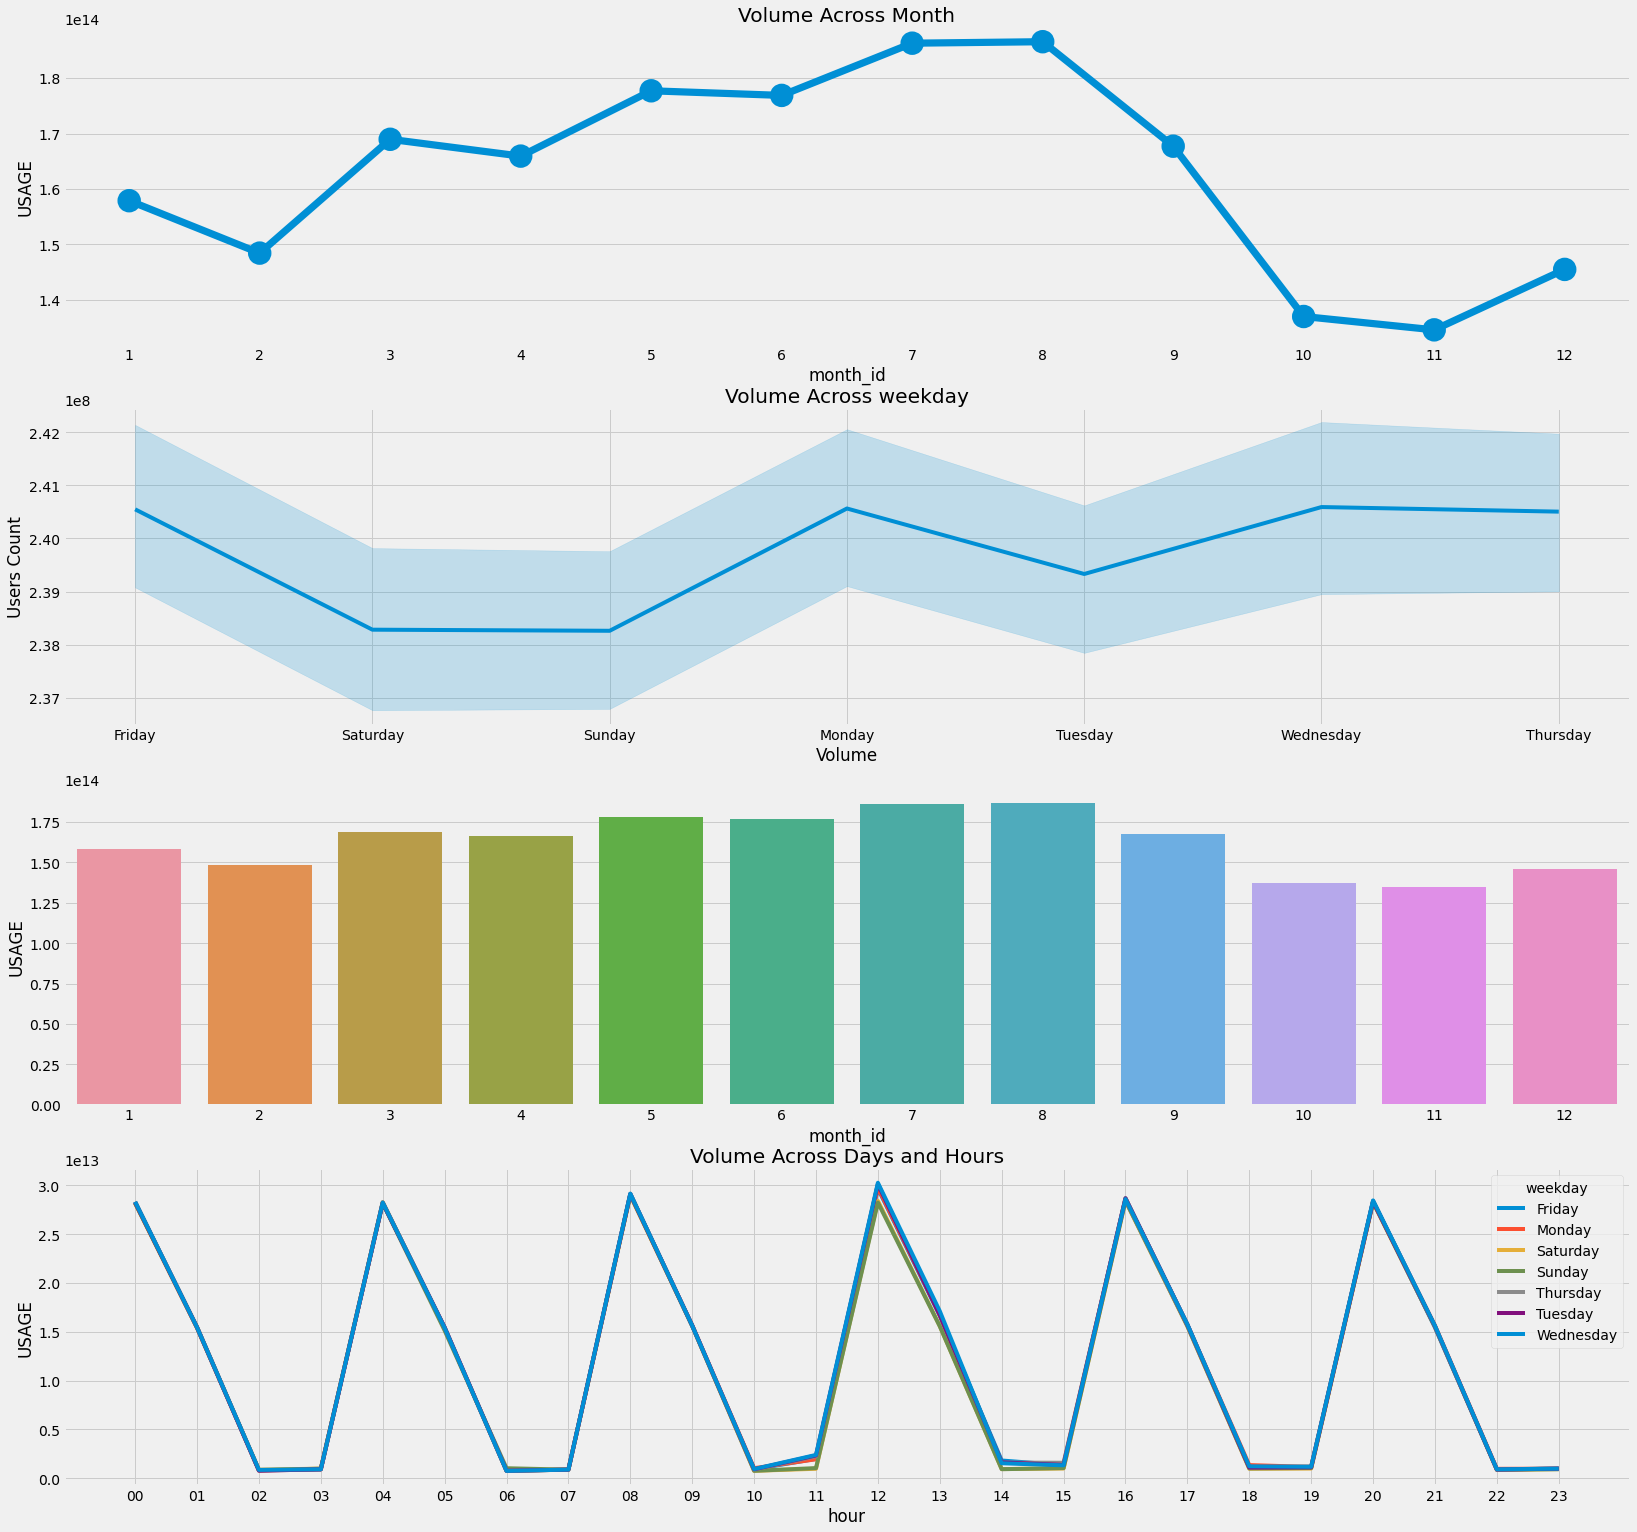

In [9]:
fig, (ax1,ax2,ax3,ax4)= plt.subplots(figsize=(15, 10), nrows=4)
fig.set_size_inches(25, 25)

hueOrder = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

monthAggregated = pd.DataFrame(Grouped_data.groupby("month_id").agg({'entries':sum, 'exits':sum, 'USAGE':sum})).reset_index()
sns.pointplot(data=monthAggregated, x="month_id",y="USAGE", ax=ax1)
ax1.set(xlabel='month_id', ylabel='USAGE',title="Volume Across Month")

hourAggregated = pd.DataFrame(Grouped_data.groupby("weekday").agg({'entries':sum, 'exits':sum, 'USAGE':sum})).reset_index()
sns.lineplot(x=Grouped_data["weekday"], y=Grouped_data["USAGE"], data=Grouped_data, markers=True, ax=ax2)
ax2.set(xlabel='Volume', ylabel='Users Count',title="Volume Across weekday",label='big')

monthAggregated = pd.DataFrame(Grouped_data.groupby("month_id").agg({'entries':sum, 'exits':sum, 'USAGE':sum})).reset_index()
sns.barplot(data=monthAggregated, x="month_id",y="USAGE", ax=ax3)

weekAggregated = pd.DataFrame(Grouped_data.groupby(["weekday", "hour"]).agg({'USAGE':sum})).reset_index()
sns.lineplot(data=weekAggregated, x="hour", y="USAGE", hue="weekday", palette=sns.color_palette(n_colors=7), ax=ax4)
ax4.set(title="Volume Across Days and Hours")

plt.show()

Observando os graficos e os diferentes periodos temporais, podemos observar variações nas visões diarias e semanais, tambem é possivel observar uma certa estabilidade no comportamento quando olhamos para ano e mes, contudo, podemos observar uma grande diminuição de volume a partir do mes 9, isso se dá pelo fato de termos o ano de 2017 só até o mes 9 

**Observando se existe alguma sasonalidade aparente**

Observando variação Semana

<Figure size 432x288 with 0 Axes>

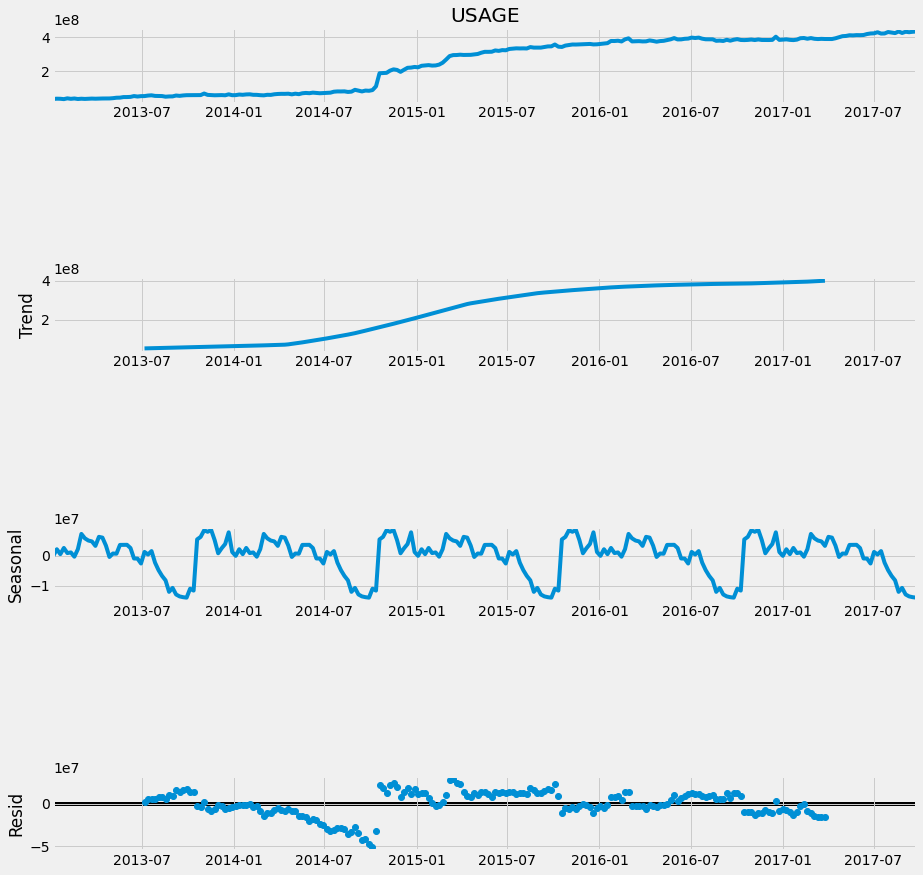

In [10]:
y = Grouped_data['USAGE'].resample('W').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 15)
plt.show()

com base em:

- Há uma tendência de aumento ao longo do tempo, e é possivel observar um padrão repetitivo, portanto há sazonalidade - movendo-se para baixo em agosto.<br>

Analisando unicamente a serie podemos observar um certo potencial na utilização com perfil diario ou semanal, contudo é necessario uma melhor analise

# Agrouping By Day

In [11]:
Grouped_data.head(2)

,station,ca,unit,date,hour,entries,exits,USAGE,weekday,weekday_id,month_id,holiday,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO
time,,,,,,,,,,,,,,,,
2016-01-01,1 AV,H007,R248,2016-01-01,00,441337662,434353336,875690998,Friday,4,1,1,1,0,1,0
2016-01-01,HOUSTON ST,R122,R290,2016-01-01,09,54385943,42599829,96985772,Friday,4,1,1,1,0,1,0


In [12]:
Daily_data = Grouped_data.groupby(['date','station','ca','unit','weekday', 'weekday_id', 'month_id', 'holiday', 'COMECO_MES',
       'FINAL_MES', 'COMECO_ANO', 'FINAL_ANO']).agg({'entries':sum, 'exits':sum, 'USAGE':sum})
Daily_data = Daily_data.reset_index()
Daily_data['year'] = pd.to_datetime(Daily_data['date']).apply(lambda x: int(x.year))

**Observando estações com maiores volumes diarimente**

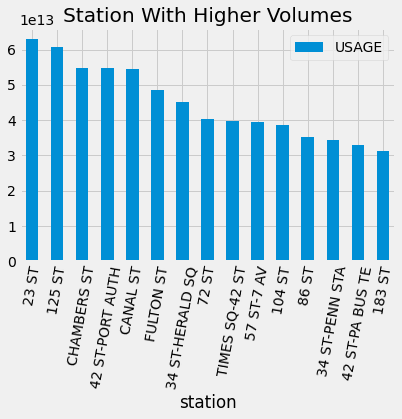

In [13]:
Daily_data.groupby(['station']).agg({'USAGE':sum}).sort_values(by='USAGE', ascending=False)[:15].plot(kind='bar')
plt.xticks(rotation=80)
plt.title('Station With Higher Volumes')
plt.show()

In [14]:
Daily_data.head(2)

,date,station,ca,unit,weekday,weekday_id,month_id,holiday,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,entries,exits,USAGE,year
0,2013-01-01,1 AVE,H007,R248,Tuesday,1,1,1,1,0,1,0,112093792,86787426,198881218,2013
1,2013-01-01,1 AVE,H008,R248,Tuesday,1,1,1,1,0,1,0,167076345,185208039,352284384,2013


Valores unicos de ca e estações 

In [15]:
len(Daily_data['ca'].unique())

745

In [16]:
len(Daily_data['station'].unique())

574

Observando influencia de **CA** e da **unit** no volume de utilizações diariamente, semanalmente e mensalmente

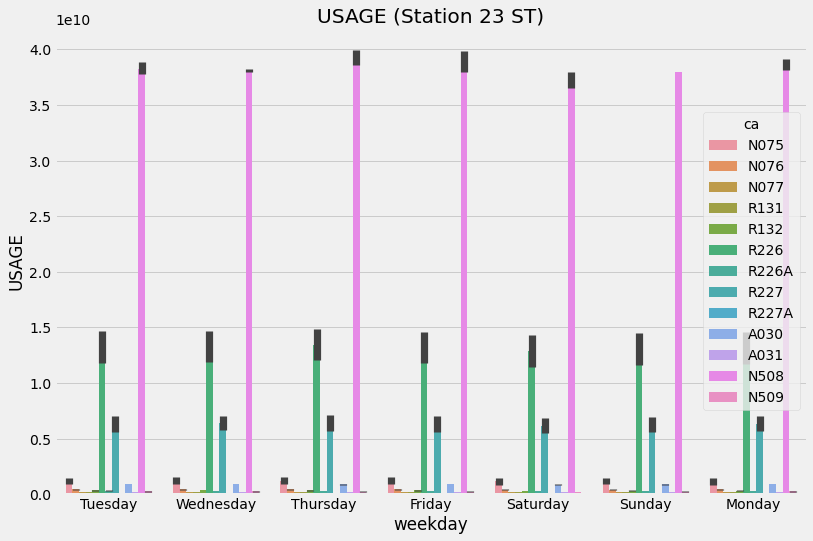

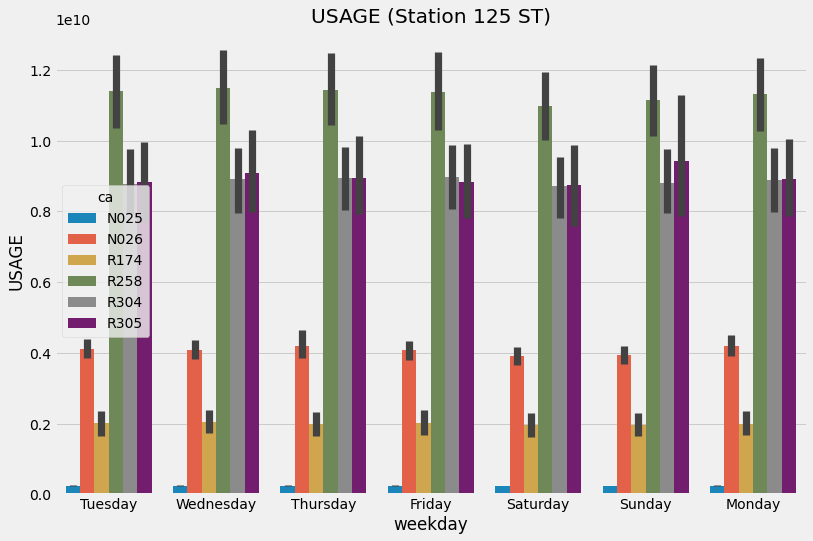

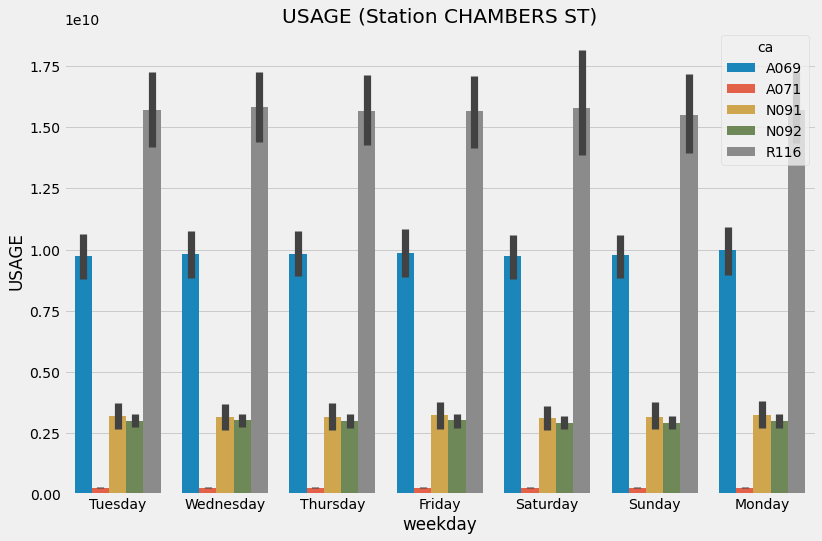

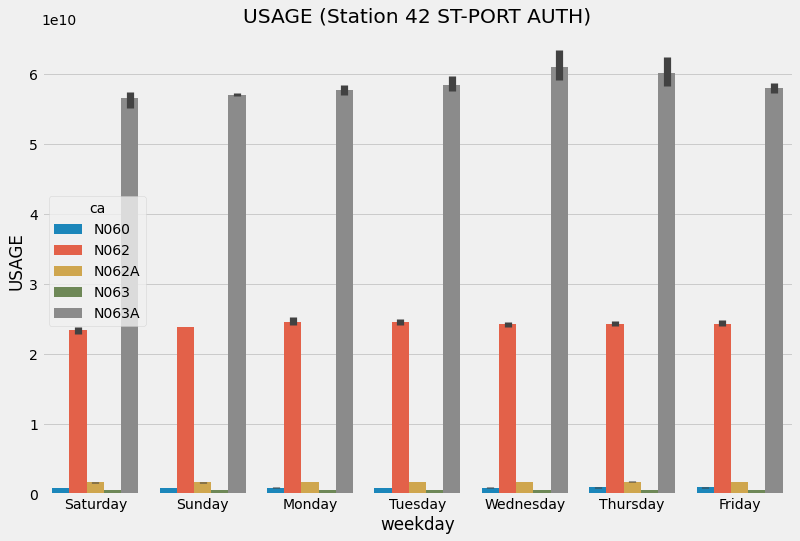

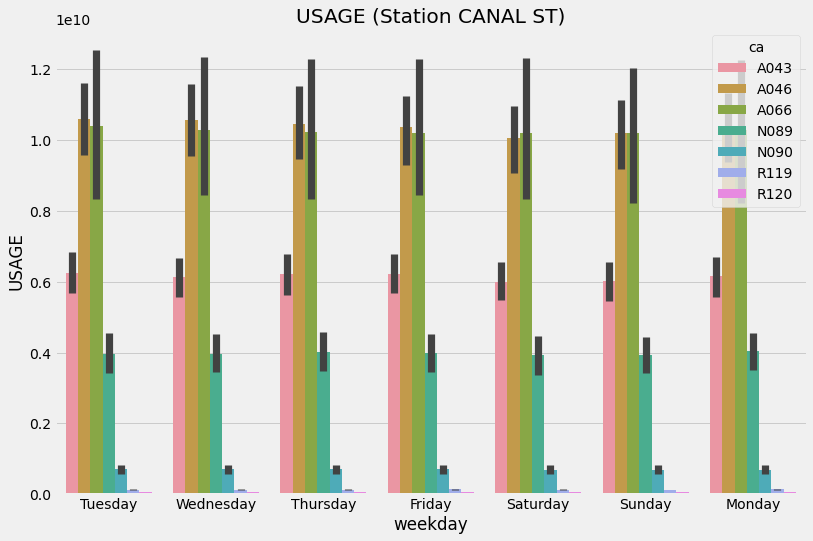

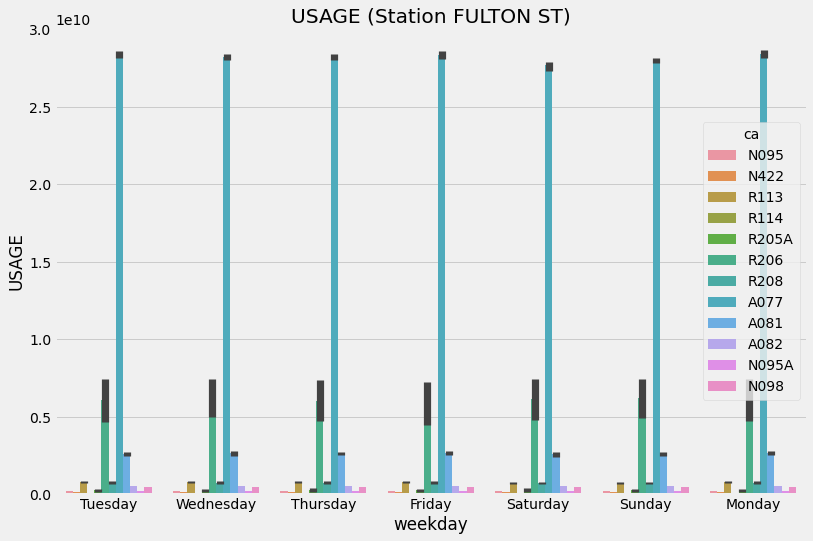

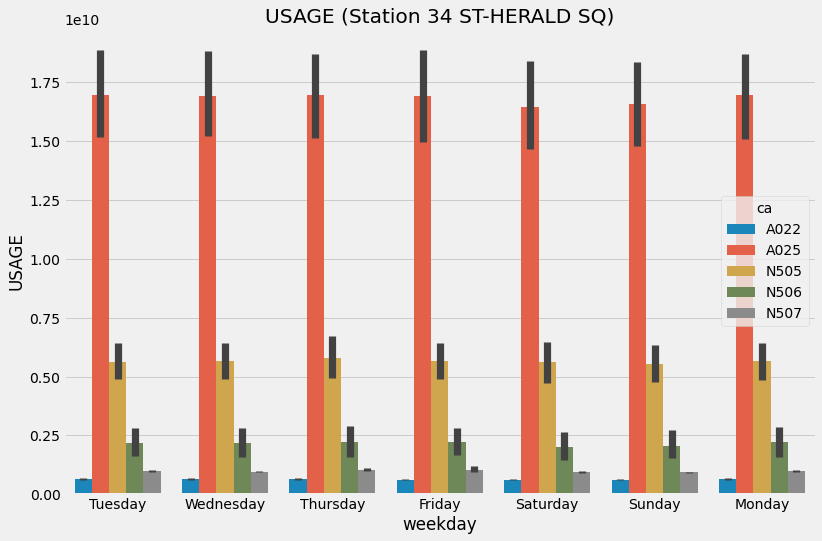

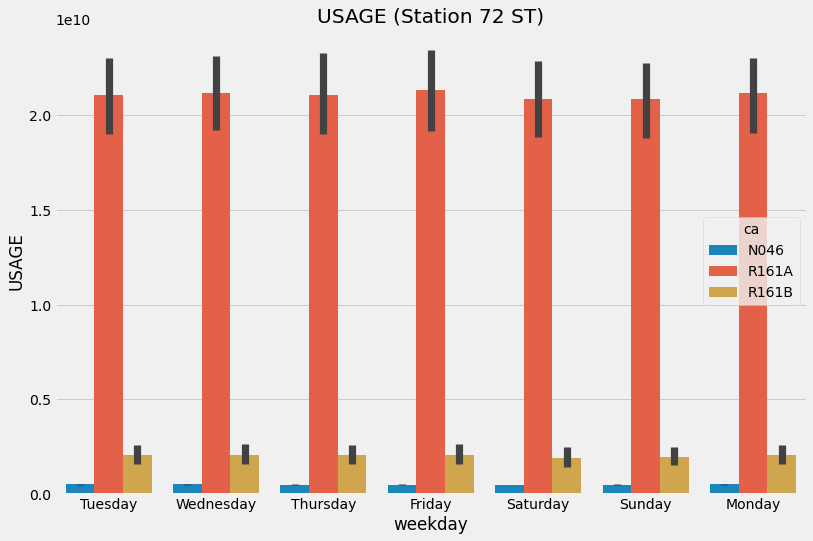

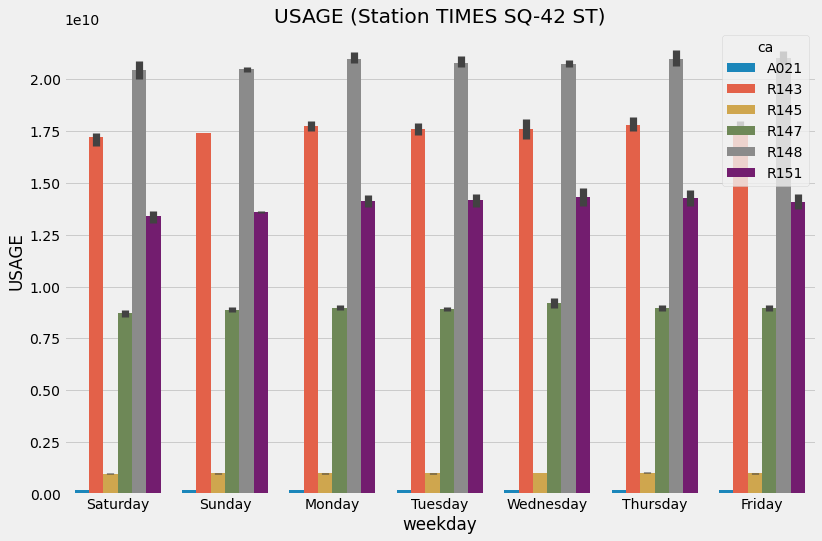

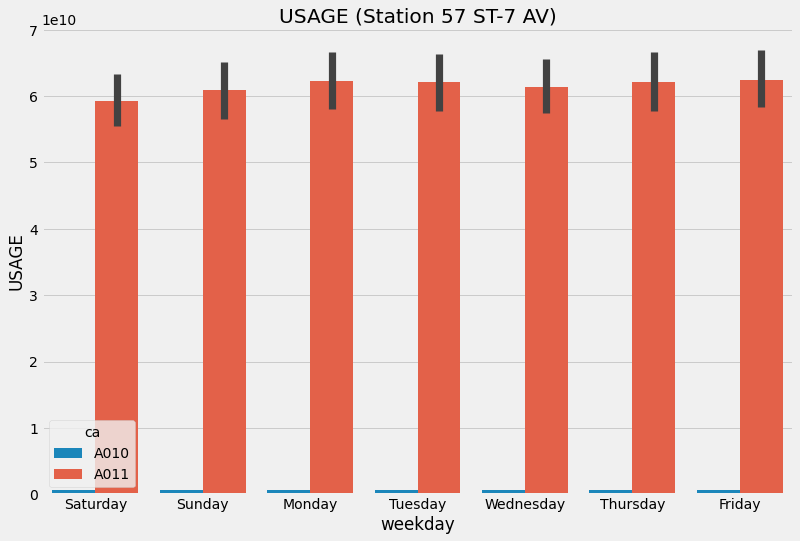

In [17]:
for station in Daily_data.groupby(['station']).agg({'USAGE':sum}).sort_values(by='USAGE', ascending=False)[:10].index:
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=Daily_data[Daily_data['station'] == station], x="weekday",y="USAGE", hue=Daily_data[Daily_data['station'] == station]['ca'])
    plt.title(f'USAGE (Station {station})')
    

Podemos observar que a variavel **ca** possui uma grande influencia no volume de utilizações do metro, observando as principais estações e as grandes variações entre si. Tambem é possivel observar uma certa constancia de utilização ao decorrer da semana com pequenas variações. 

Analise, volume das estações ao decorrer das semanas olhando para variavel **UNIT**

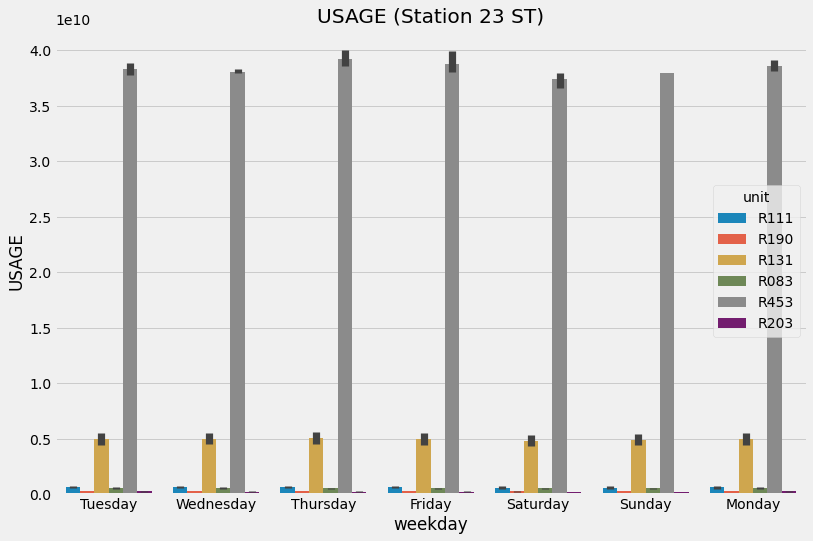

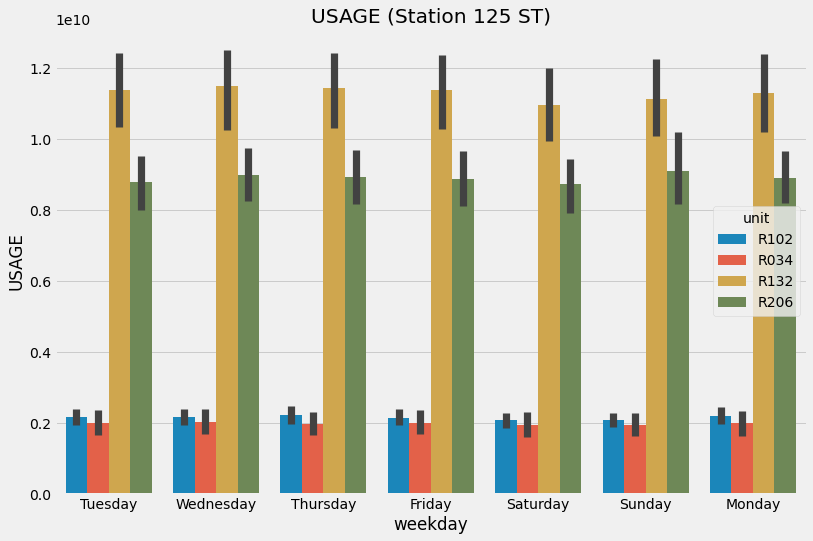

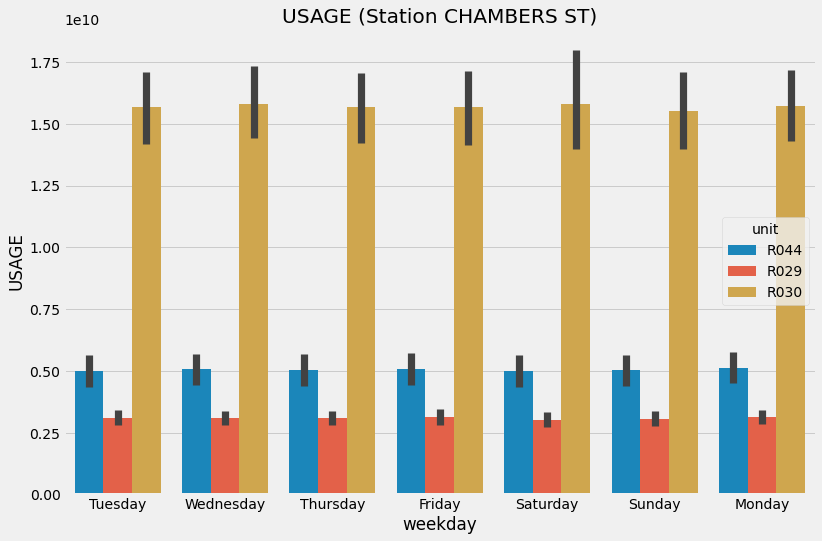

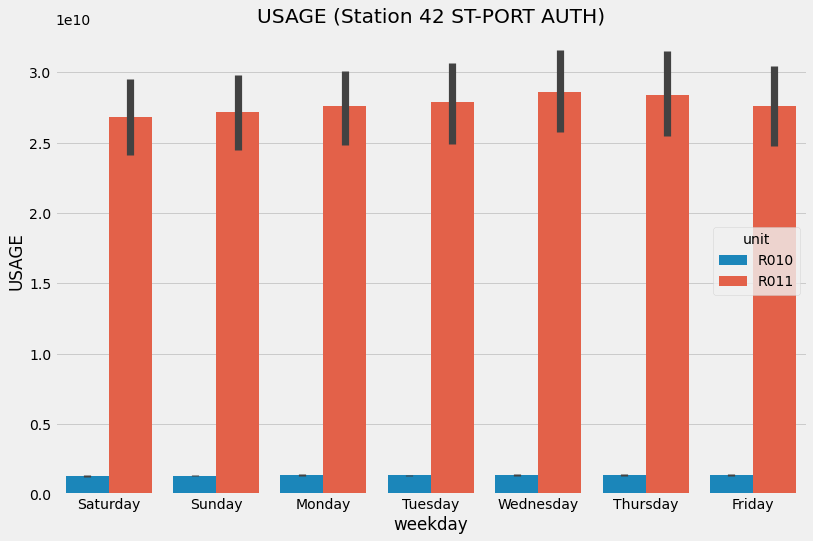

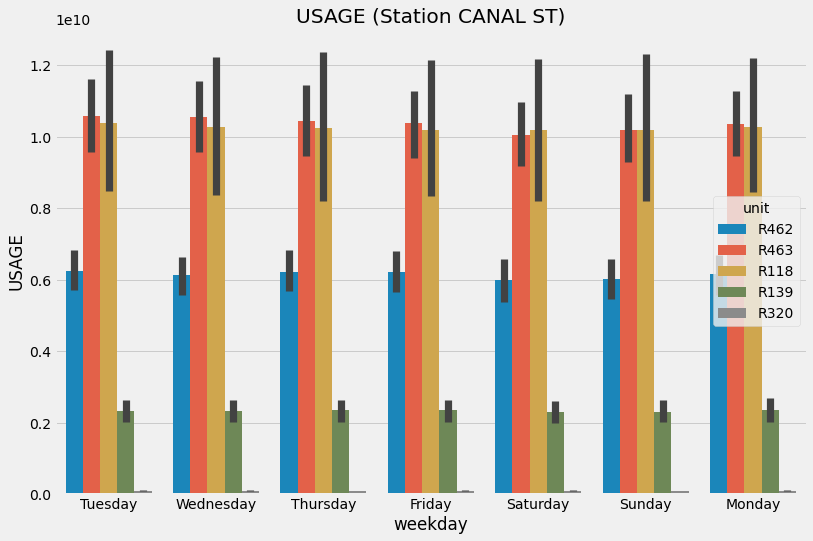

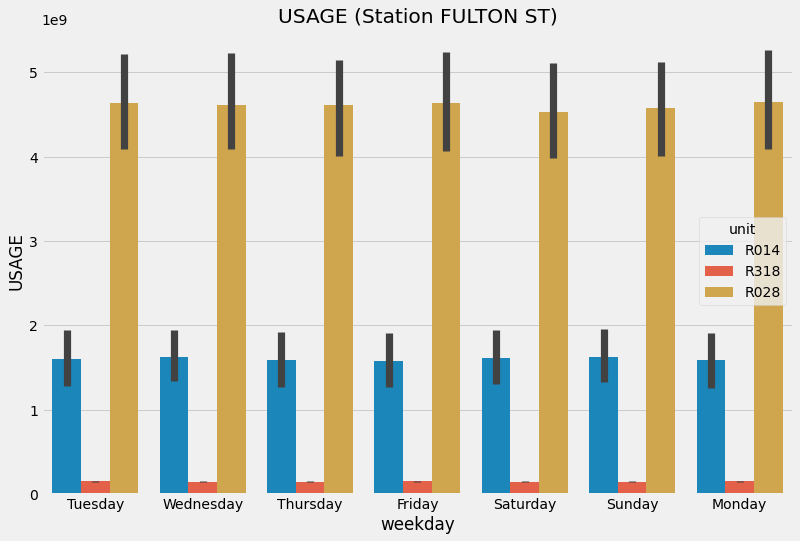

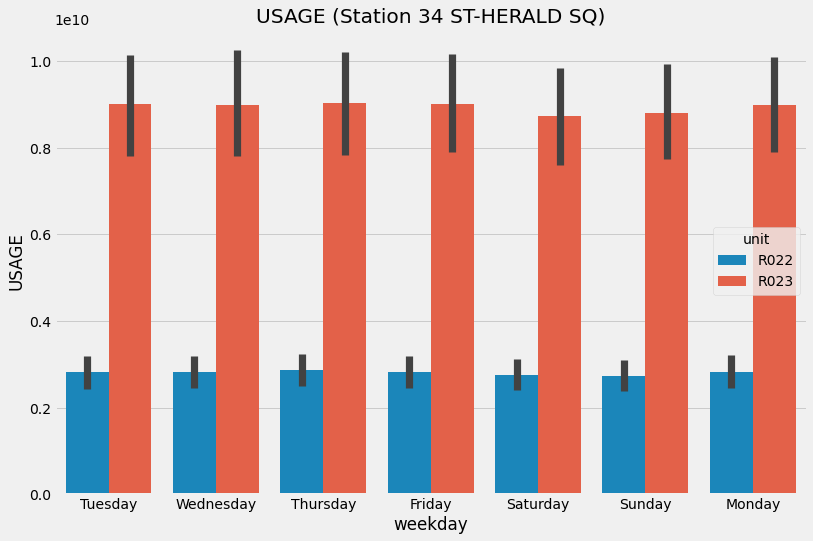

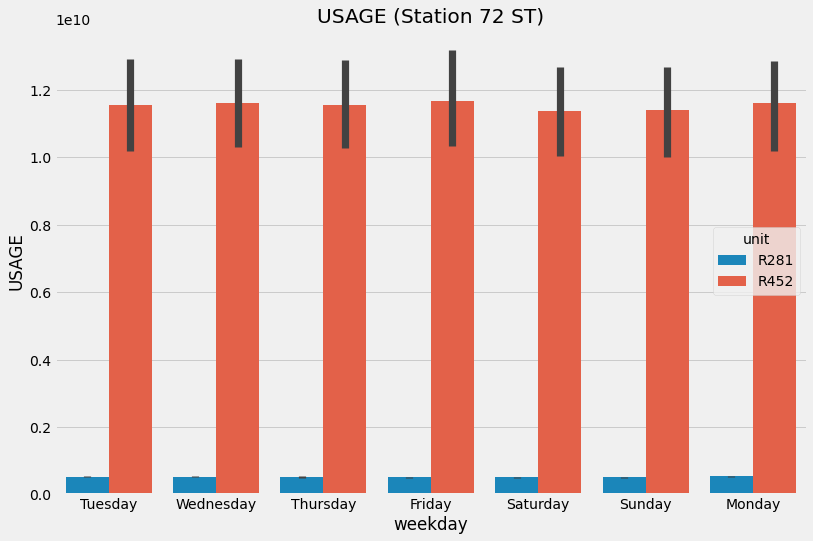

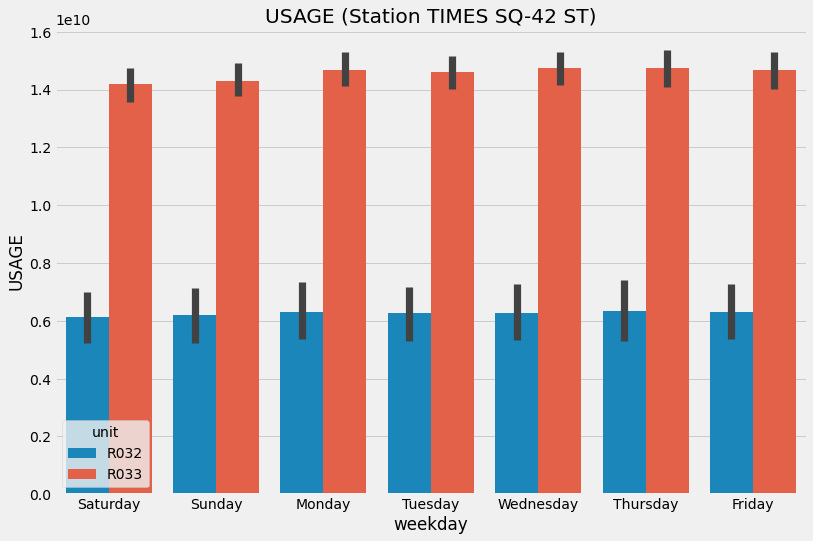

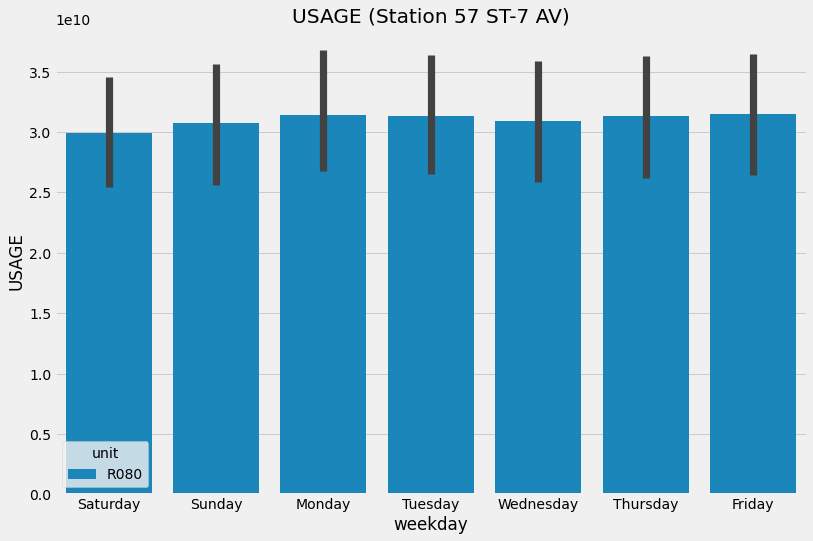

In [18]:
for station in Daily_data.groupby(['station']).agg({'USAGE':sum}).sort_values(by='USAGE', ascending=False)[:10].index:
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=Daily_data[Daily_data['station'] == station], x="weekday",y="USAGE", hue=Daily_data[Daily_data['station'] == station]['unit'])
    plt.title(f'USAGE (Station {station})')

Podemos observar que a variavel **UNIT** possui uma grande influencia no volume de utilizações do metro, observando as principais estações e as grandes variações entre si. Tambem é possivel observar uma certa constancia de utilização ao decorrer da semana com pequenas variações.

Analise volume das estações ao decorrer dos meses olhando para variavel **UNIT**

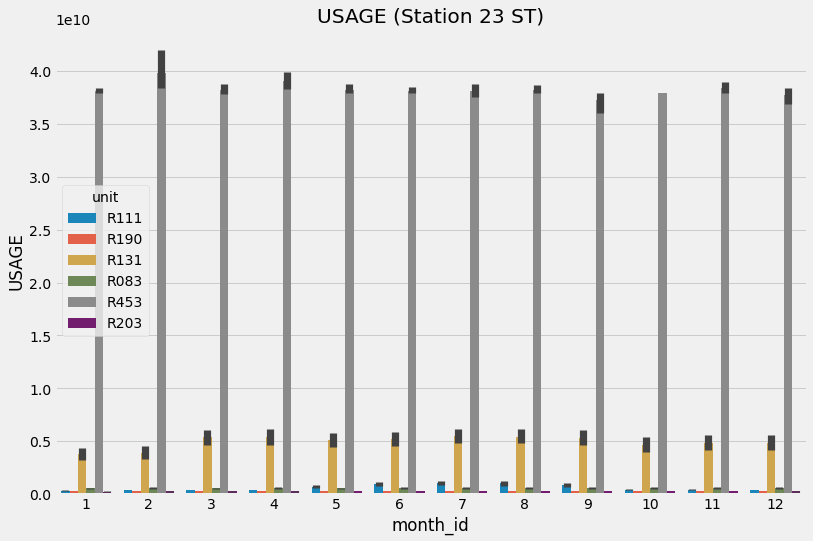

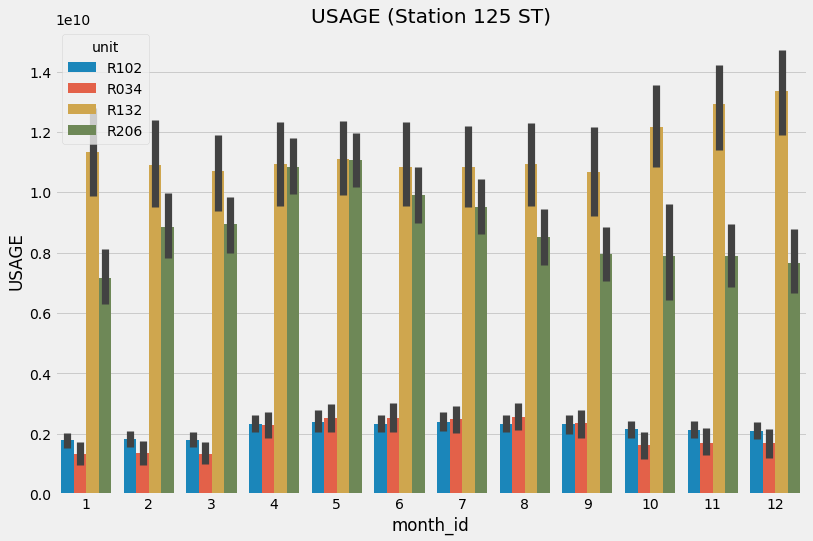

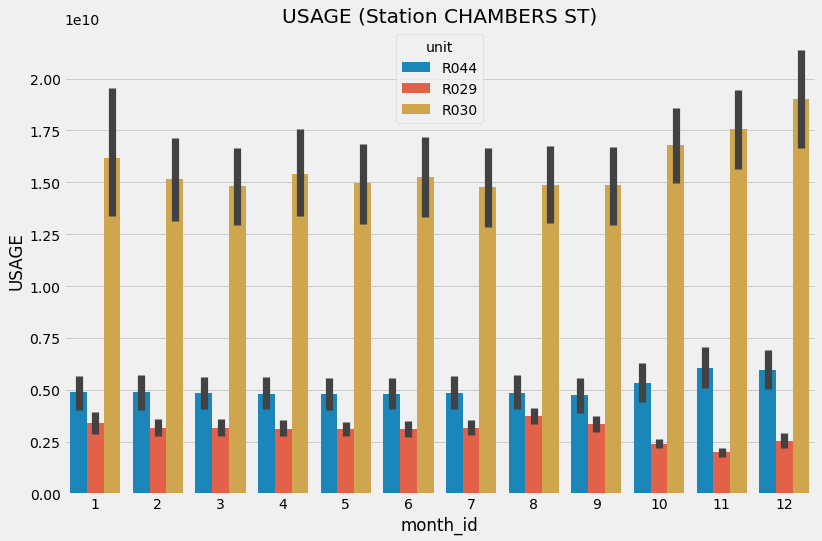

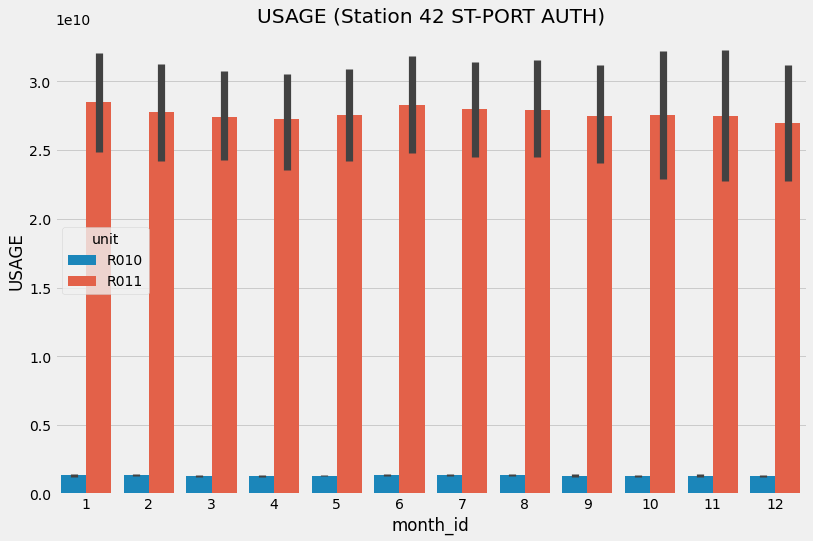

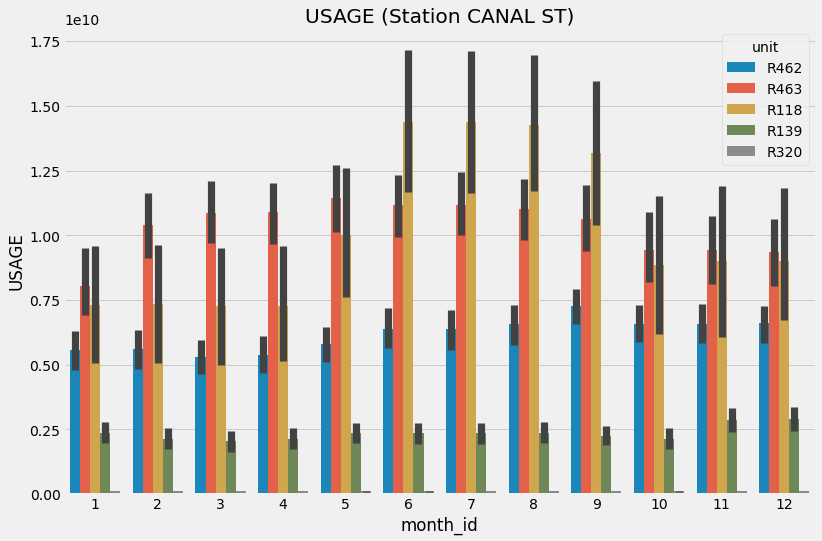

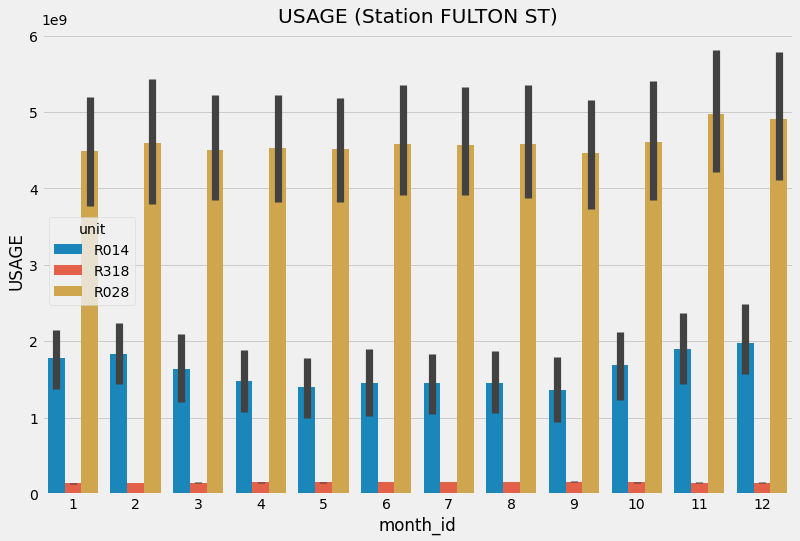

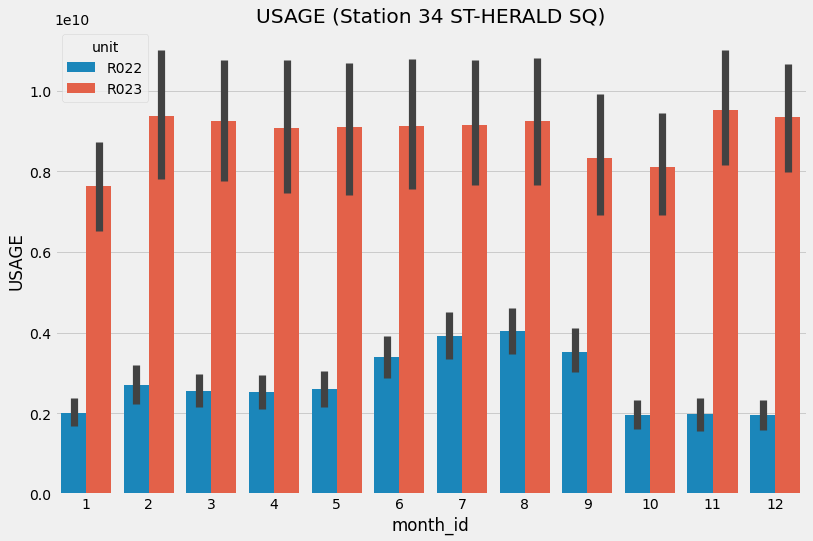

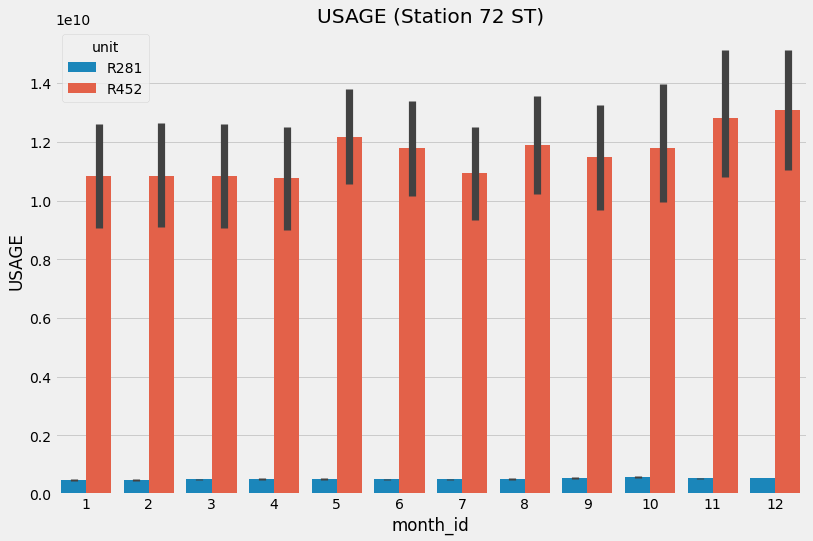

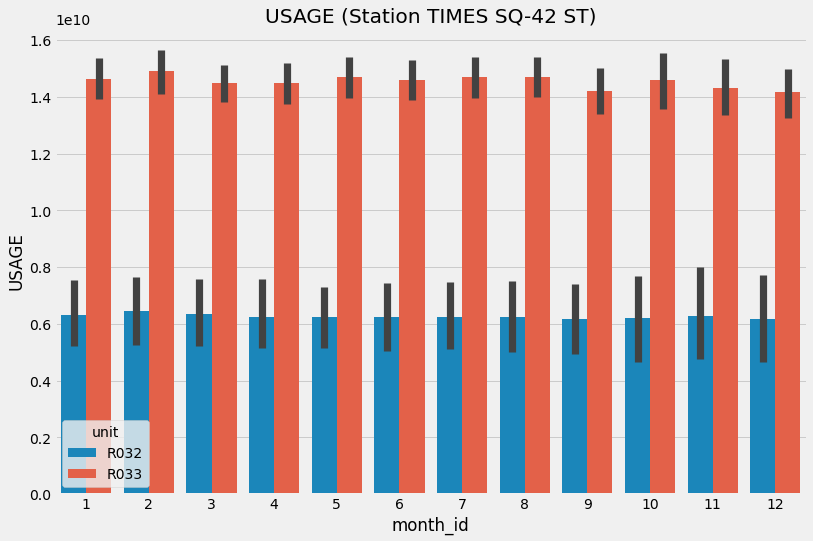

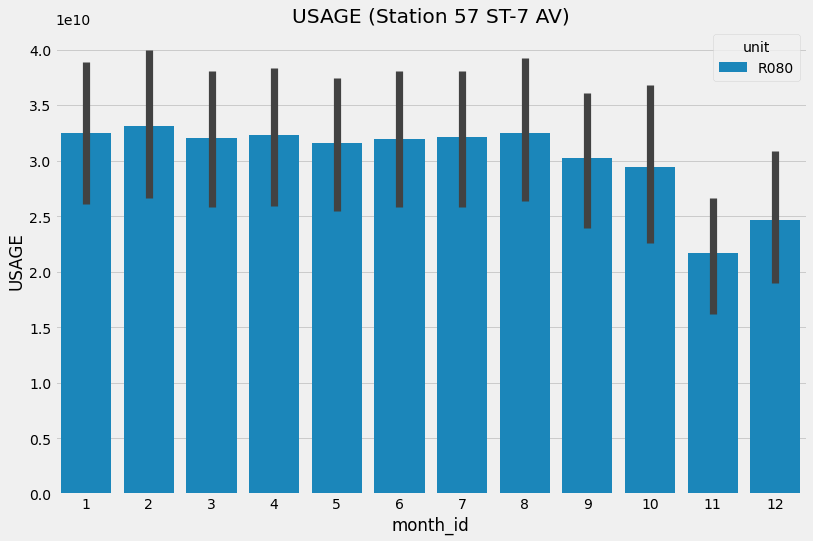

In [19]:
for station in Daily_data.groupby(['station']).agg({'USAGE':sum}).sort_values(by='USAGE', ascending=False)[:10].index:
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=Daily_data[Daily_data['station'] == station], x="month_id",y="USAGE", hue=Daily_data[Daily_data['station'] == station]['unit'])
    plt.title(f'USAGE (Station {station})')

Assim como nos graficos anteriores, podemos observar que a variavel **UNIT** possui uma grande influencia no volume de utilizações do metro, observando as principais estações e as grandes variações entre si. Contudo, diferentemente das visões anteriores é possivel observar uma certa variação de utilização ao decorrer dos meses com pequenas variações.

**Observando influencia dos feriados nas volumetrias dos metros**

In [20]:
Holiday_data = Daily_data.groupby(['date','holiday']).agg({'USAGE':sum})
Holiday_data = Holiday_data.reset_index()

In [21]:
Holiday_data.index = Holiday_data['date'].apply(pd.to_datetime)
Holiday_data.drop(columns=['date'], inplace=True)

Serie temporal dos meses/anos utilizando uma janela mensal

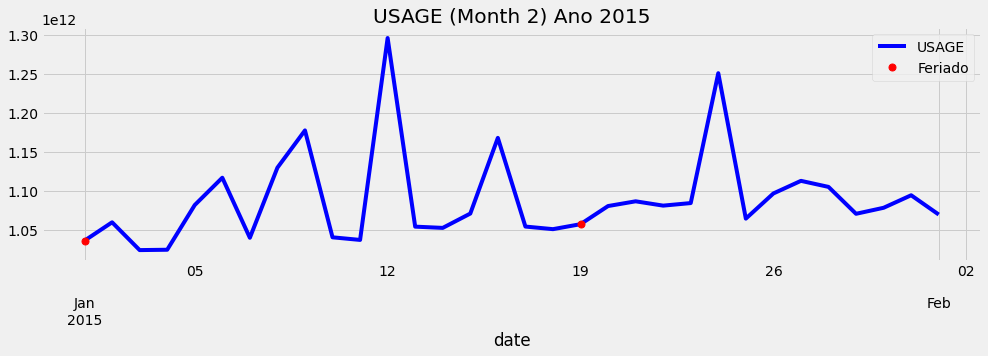

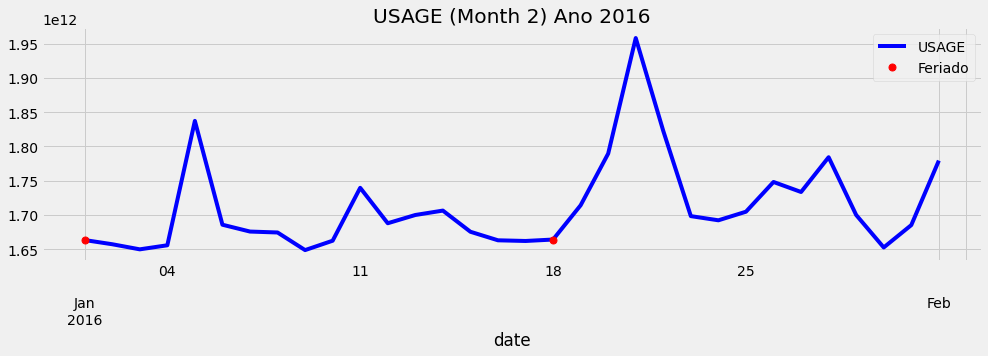

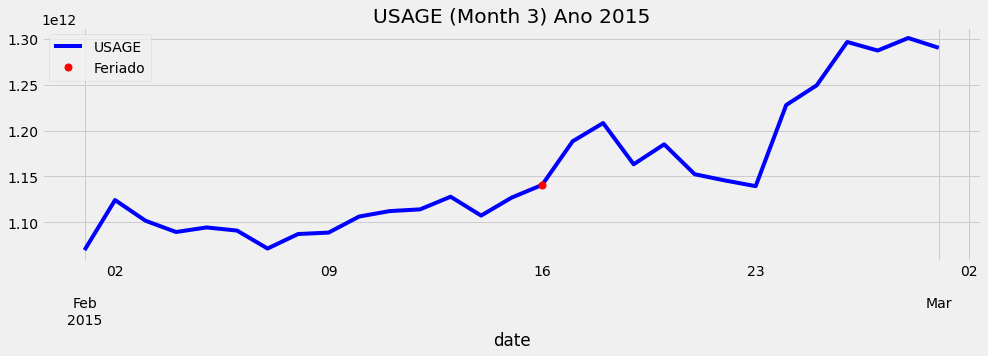

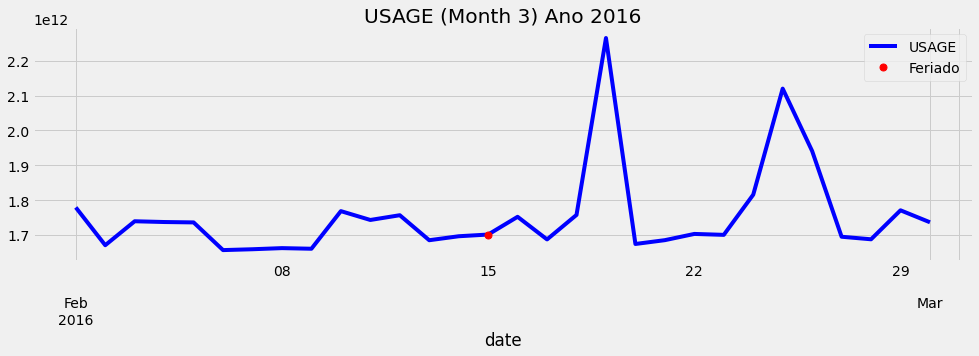

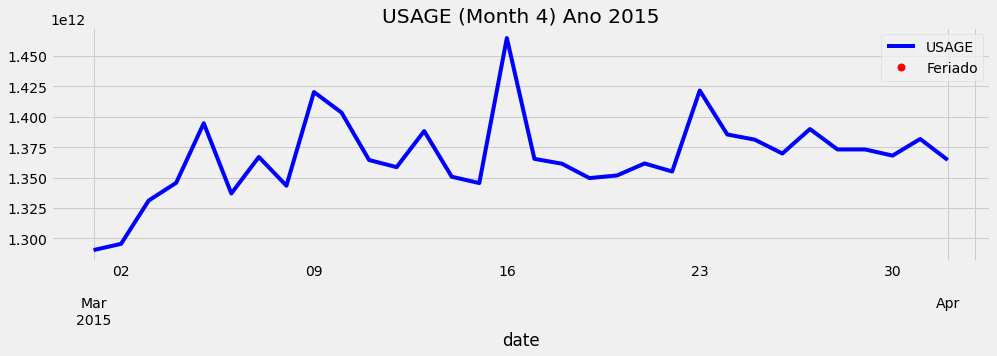

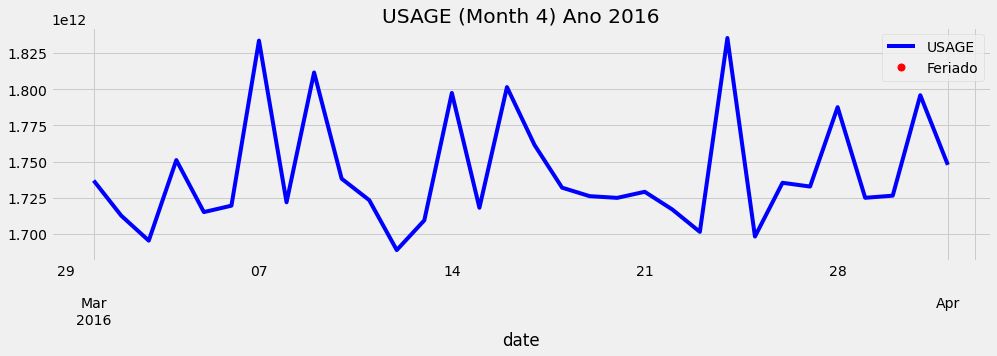

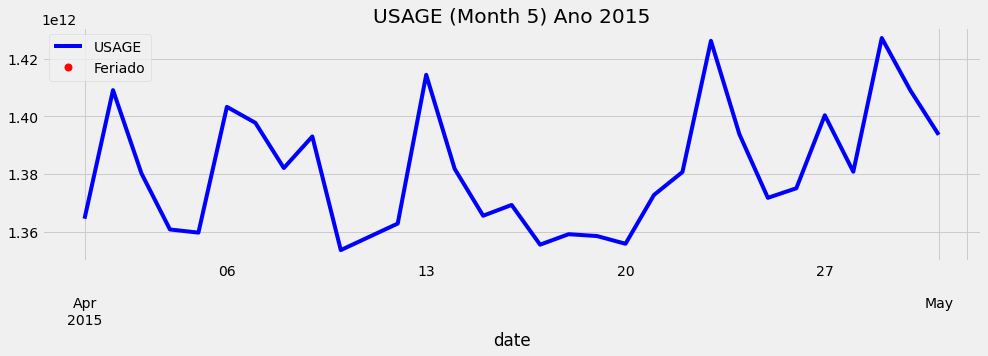

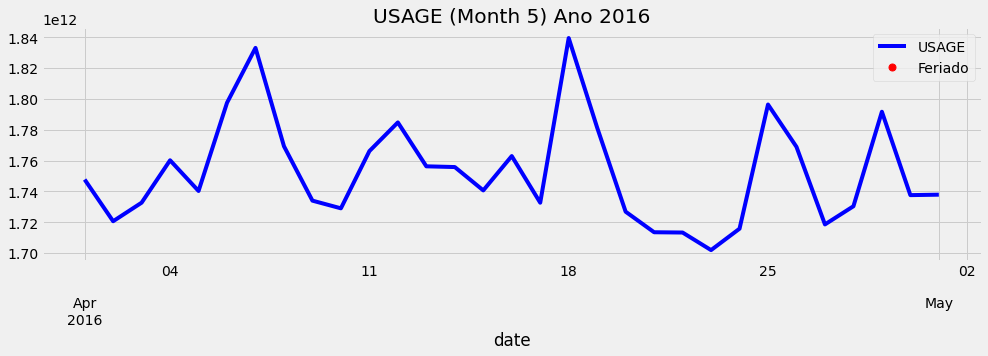

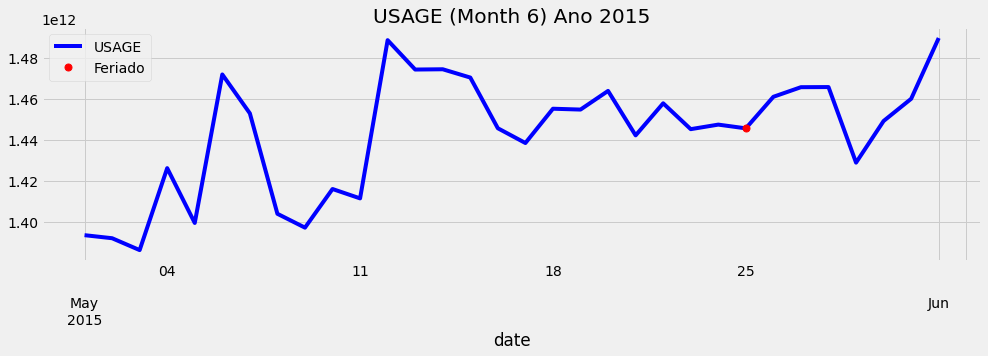

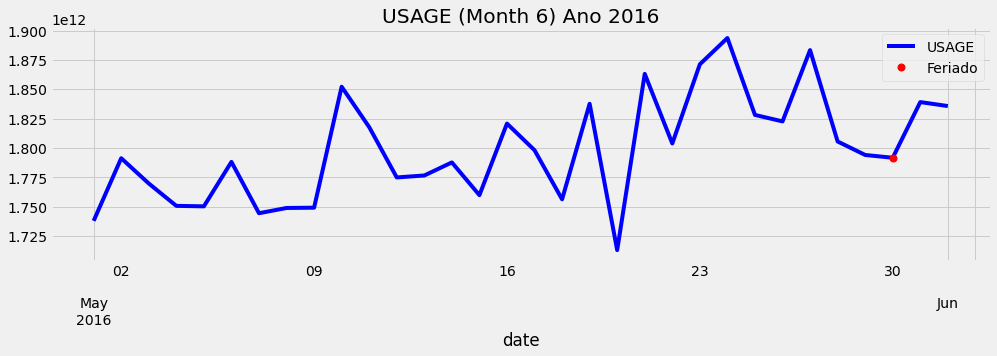

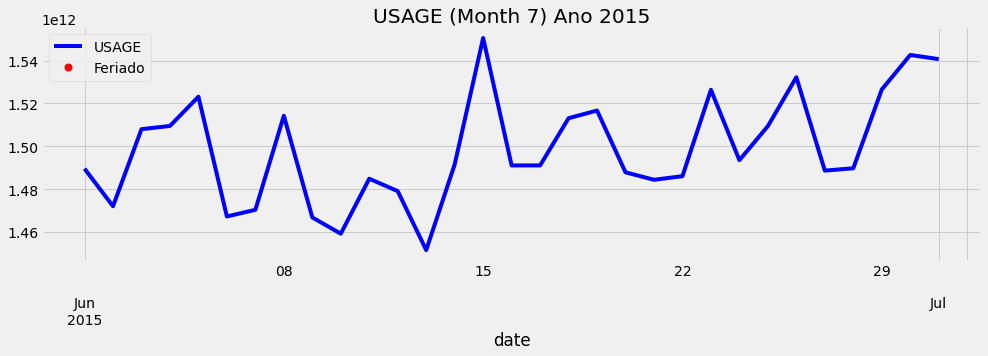

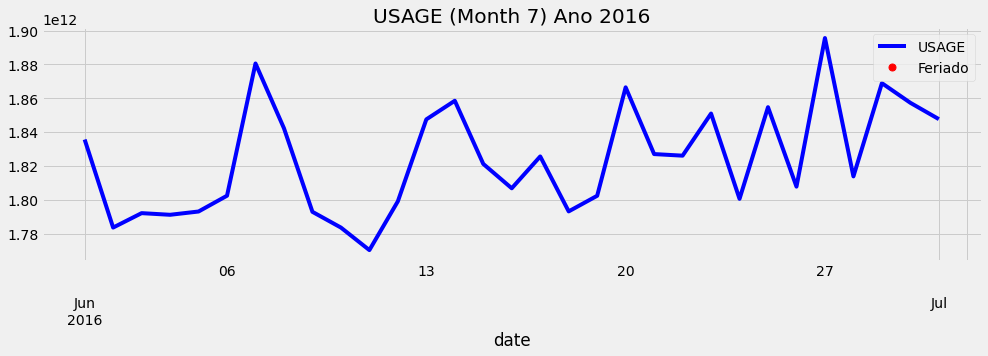

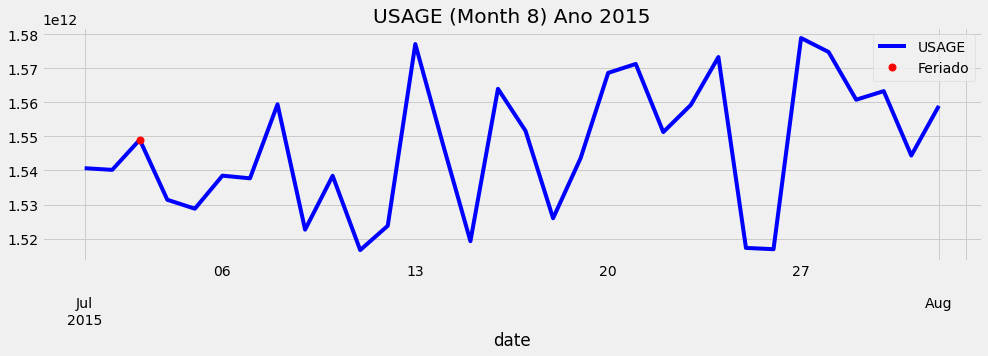

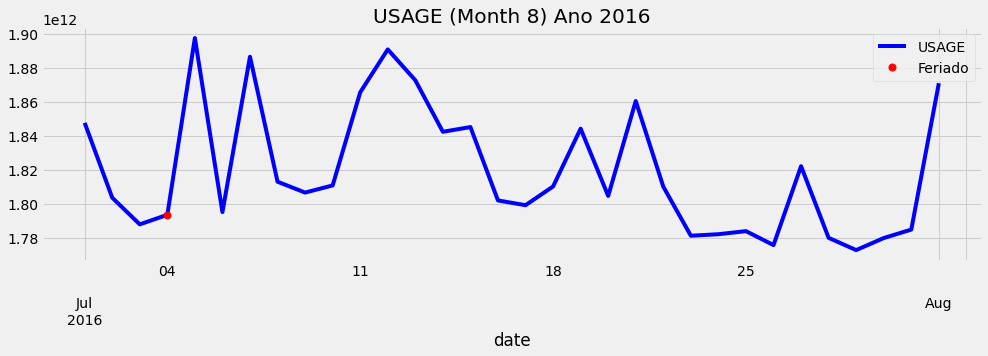

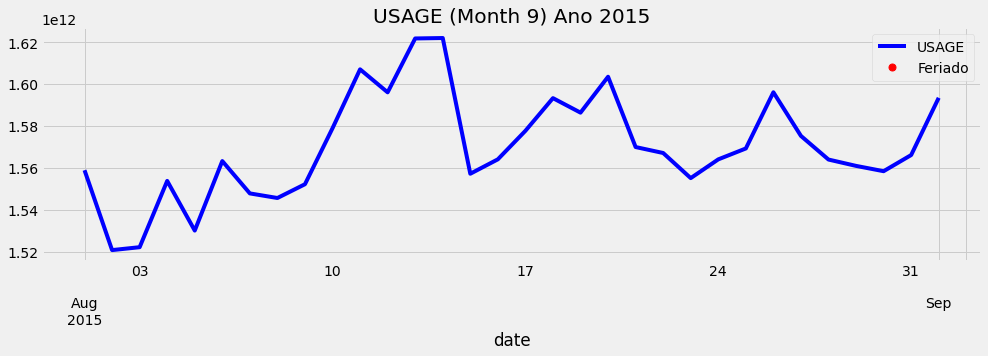

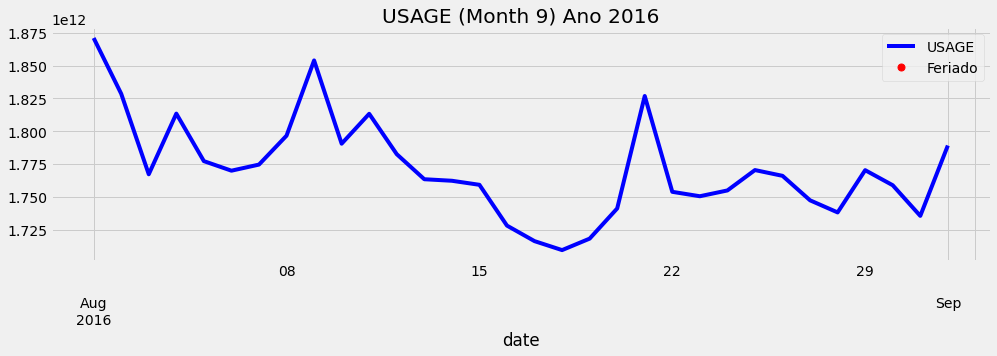

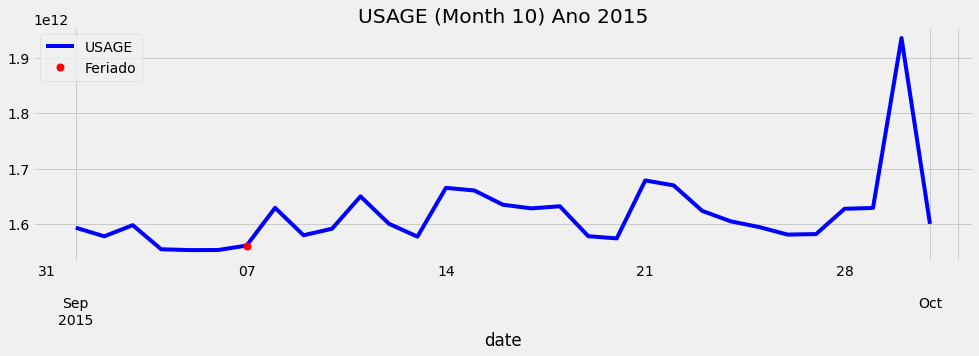

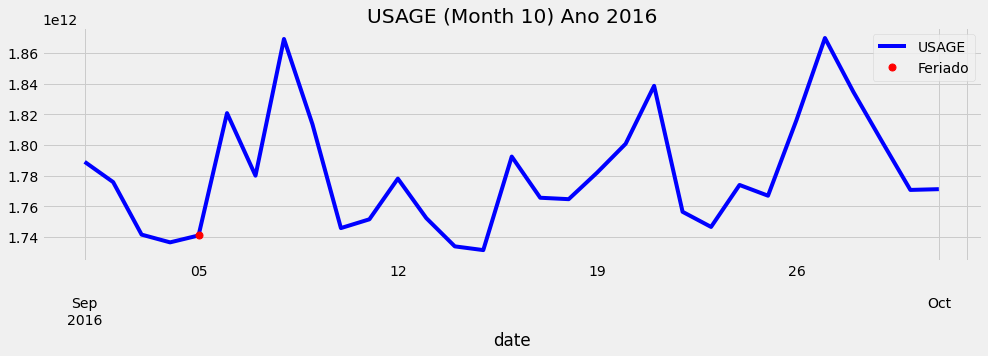

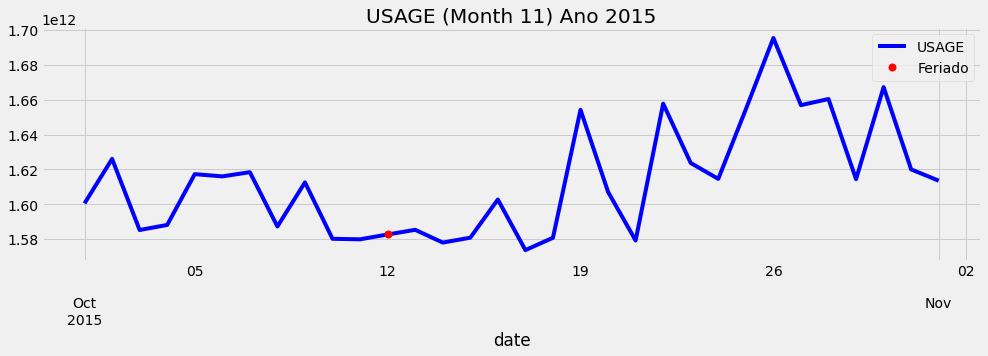

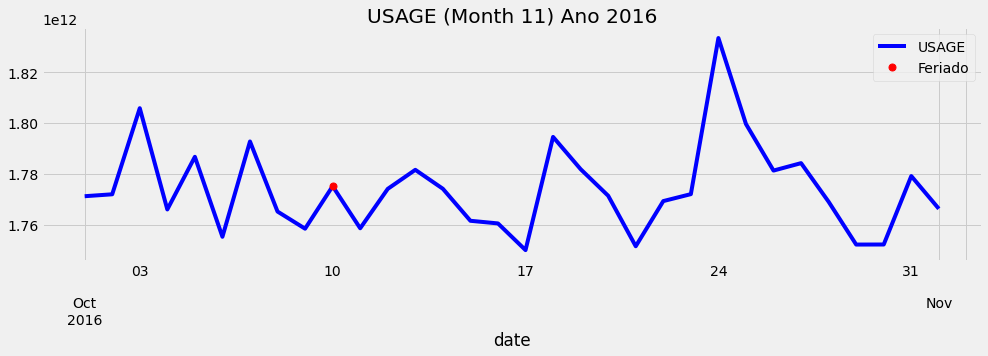

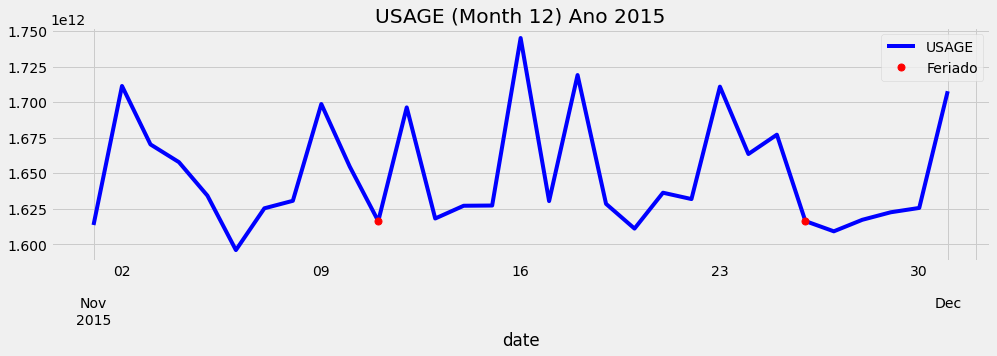

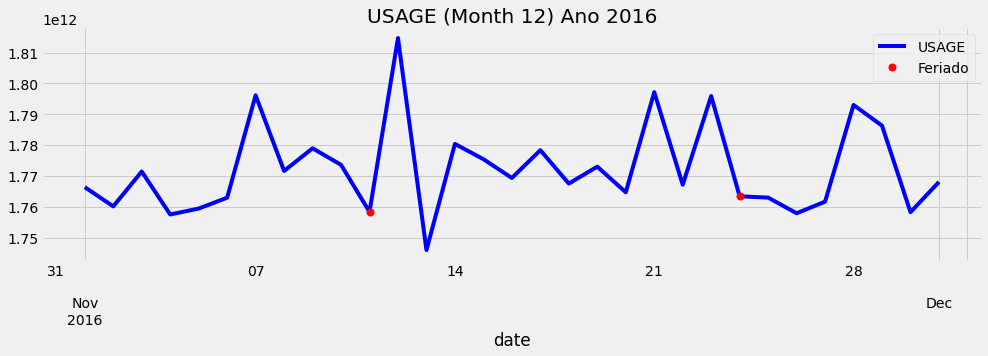

CPU times: user 3.5 s, sys: 35.5 ms, total: 3.53 s
Wall time: 3.5 s


In [22]:
%%time 

target = 'USAGE'

for month in Daily_data['month_id'].unique():
    
    for ano in range(15, 17):
        
        if month > 1:

            Holiday_data.loc[f'20{ano}-{month-1}-01':f'20{ano}-{month}-01']\
            ['USAGE'].plot(figsize=(15, 4), color='blue')

            plt.plot(Holiday_data.loc[f'20{ano}-{month-1}-01':f'20{ano}-{month}-01']\
            [Holiday_data['holiday'] == 1]['USAGE'],
                     'ko', markersize=7, color='red', label = "Feriado")


            plt.title(f'{target} (Month {month}) Ano 20{ano}')
            plt.grid(True)
            plt.axis('tight')
            plt.legend(loc="best");
            plt.show()

Observando os graficos dos anos e meses, é possivel observar certo padrão de crescimento de utilizações em alguns feriados 

In [23]:
Daily_data.head(2)

,date,station,ca,unit,weekday,weekday_id,month_id,holiday,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,entries,exits,USAGE,year
0,2013-01-01,1 AVE,H007,R248,Tuesday,1,1,1,1,0,1,0,112093792,86787426,198881218,2013
1,2013-01-01,1 AVE,H008,R248,Tuesday,1,1,1,1,0,1,0,167076345,185208039,352284384,2013


# Month Data 

In [24]:
Month_data = Grouped_data.copy()

In [25]:
Month_data['date'] = Month_data['date'].apply(lambda x: x[:7])
Month_data = Month_data.groupby(['date','station','ca','unit', 'month_id']).agg({'entries':sum, 'exits':sum, 'USAGE':sum})

In [26]:
Month_data = Month_data.reset_index()
Month_data.index = Month_data['date'].apply(pd.to_datetime)
Month_data.drop(columns=['date'], inplace=True)

In [27]:
Month_data.head(2)

,station,ca,unit,month_id,entries,exits,USAGE
date,,,,,,,
2013-01-01,1 AVE,H007,R248,1,3094242817,2120638430,5214881247
2013-01-01,1 AVE,H008,R248,1,6627934018,7515792524,14143726542


In [28]:
Month_data['year'] = Month_data.index.year

# Observando Correlaçao entre os valores

Geração dos encoders para transformação das colunas categoricas para analise 

In [29]:
get_encoders(Month_data)

Quantidade de elementos unicos: 574
File Name: station.pkl
Quantidade de elementos unicos: 745
File Name: ca.pkl
Quantidade de elementos unicos: 471
File Name: unit.pkl


Import encoders para transformação

In [30]:
le_station = pickle.load(open('station.pkl', 'rb'))
le_ca = pickle.load(open('ca.pkl', 'rb'))
le_unit = pickle.load(open('unit.pkl', 'rb'))

Aplicação dos encoders nas colunas 

In [31]:
Month_data['station'] = Month_data['station'].astype('category')
Month_data['station'] = Month_data['station'].apply(lambda x: apply_CID(x, le_station))

Month_data['ca'] = Month_data['ca'].astype('category')
Month_data['ca'] = Month_data['ca'].apply(lambda x: apply_CID(x, le_ca))

Month_data['unit'] = Month_data['unit'].astype('category')
Month_data['unit'] = Month_data['unit'].apply(lambda x: apply_CID(x, le_unit))

Transformação das colunas para numericas para analise 

In [32]:
Month_data['station'] = Month_data['station'].astype(int)
Month_data['ca'] = Month_data['ca'].astype(int)
Month_data['unit'] = Month_data['unit'].astype(int)

**Matriz de correlação**

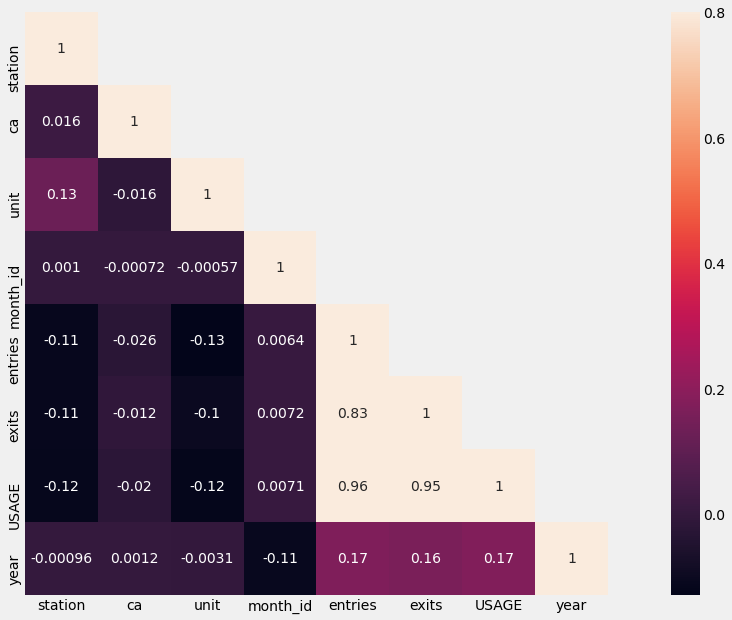

In [33]:
corrMatt = Month_data.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

Observando a correlação podemos observar **entries** e **exit** possuem alta correlação com **usage** contudo eles fazem parte da composição do valor. Então não existe nenhuma correlação a ser destacada

In [34]:
Month_data.head(1)

,station,ca,unit,month_id,entries,exits,USAGE,year
date,,,,,,,,
2013-01-01,1,125,238,1,3094242817,2120638430,5214881247,2013


In [35]:
Month_data.shape

(41619, 8)

In [36]:
Month_data.dtypes

station     int64
ca          int64
unit        int64
month_id    int64
entries     int64
exits       int64
USAGE       int64
year        int64
dtype: object

Observando variação temporal de algumas estações

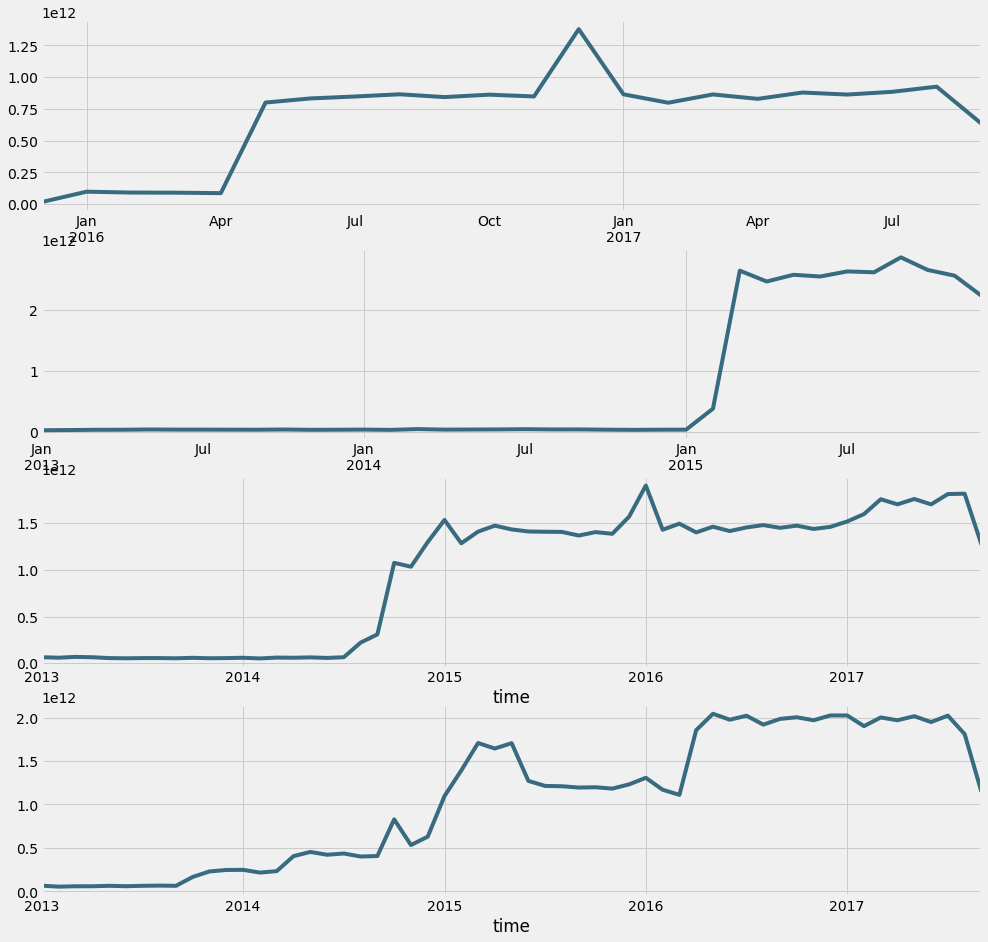

In [37]:
usage_a = Grouped_data[Grouped_data.station == '47-50 STS ROCK']['USAGE'].sort_index(ascending = True)
usage_b = Grouped_data[Grouped_data.station == '57 ST-7 AVE']['USAGE'].sort_index(ascending = True) # solve the reverse order
usage_c = Grouped_data[Grouped_data.station == 'CHAMBERS ST']['USAGE'].sort_index(ascending = True)
usage_d = Grouped_data[Grouped_data.station == '125 ST']['USAGE'].sort_index(ascending = True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 8))
c = '#386B7F'

f.set_size_inches(15, 15)

# store types
usage_a.resample('MS').sum().plot(color = c, ax = ax1)
usage_b.resample('MS').sum().plot(color = c, ax = ax2)
usage_c.resample('MS').sum().plot(color = c, ax = ax3)
usage_d.resample('MS').sum().plot(color = c, ax = ax4)
plt.show()

# Daily Modeling

Agrupamento dos dados diariamente utilizando a estação a variavel ca como chave

In [38]:
Daily_data = Grouped_data.groupby(['date','station','ca','weekday', 'weekday_id', 'month_id', 'holiday', 'COMECO_MES',
       'FINAL_MES', 'COMECO_ANO', 'FINAL_ANO']).agg({'entries':sum, 'exits':sum, 'USAGE':sum})

Daily_data = Daily_data.reset_index()
Daily_data['year'] = pd.to_datetime(Daily_data['date']).apply(lambda x: int(x.year))

In [39]:
Daily_data.head(2)

,date,station,ca,weekday,weekday_id,month_id,holiday,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,entries,exits,USAGE,year
0,2013-01-01,1 AVE,H007,Tuesday,1,1,1,1,0,1,0,112093792,86787426,198881218,2013
1,2013-01-01,1 AVE,H008,Tuesday,1,1,1,1,0,1,0,167076345,185208039,352284384,2013


In [40]:
Daily_data.index =  pd.to_datetime(Daily_data['date'])
Daily_data.drop(columns=['date'], inplace=True)

In [41]:
Daily_data.head(2)

,station,ca,weekday,weekday_id,month_id,holiday,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,entries,exits,USAGE,year
date,,,,,,,,,,,,,,
2013-01-01,1 AVE,H007,Tuesday,1,1,1,1,0,1,0,112093792,86787426,198881218,2013
2013-01-01,1 AVE,H008,Tuesday,1,1,1,1,0,1,0,167076345,185208039,352284384,2013


In [42]:
Daily_data.shape

(1242522, 14)

Aplicação da função de redução de memoria

In [43]:
Daily_data = reduce_mem_usage(Daily_data)

Mem. usage decreased to 77.02 Mb (45.8% reduction)


Pre definição dos lags a serem gerados 

In [44]:
lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 60, 90, 365]

Aplicação das funções de lag e rolling mean

In [46]:
Daily_data = lag_features(Daily_data, lags)
Daily_data = roll_mean_features(Daily_data, lags)

Seleção de periodo de treino e de teste

In [47]:
train = Daily_data.sort_index().loc[:'2017-03']
test = Daily_data.sort_index().loc['2017-03':]

Aplicação da função de geração de dummies

In [48]:
df_test = pd.get_dummies(train, columns = ['station','ca','month_id','weekday_id','holiday','year'])
colunas_dummies = df_test.columns

In [49]:
#pickle.dump(colunas, open('columns.pkl', 'wb'))

Aplicação da função de redução de memoria

In [50]:
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 1585.98 Mb (6.5% reduction)


In [51]:
Daily_data = None
DATA = None

In [52]:
import gc
gc.collect()

0

In [53]:
df_test.head(2)

,weekday,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,entries,exits,USAGE,usage_lag_1,usage_lag_2,...,weekday_id_4,weekday_id_5,weekday_id_6,holiday_0,holiday_1,year_2013,year_2014,year_2015,year_2016,year_2017
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Tuesday,1,0,1,0,112093792,86787426,198881218,NaN,NaN,...,0,0,0,0,1,1,0,0,0,0
2013-01-01,Tuesday,1,0,1,0,167076345,185208039,352284384,NaN,NaN,...,0,0,0,0,1,1,0,0,0,0


Aplicação da função de geração de dummies utilizando a função de parelelização

In [54]:
DATA_Transformed_1 = parallelize_dataframe(test, dummies_test)

Aplicação da função de redução de memoria

In [55]:
DATA_Transformed_1 = reduce_mem_usage(DATA_Transformed_1)

Mem. usage decreased to 195.30 Mb (0.0% reduction)


Dropando colunas transformadas em dummies

In [56]:
train.drop(columns=['station','ca','month_id','weekday_id','holiday','year','weekday','entries','exits'], inplace=True)
test.drop(columns=['station','ca','month_id','weekday_id','holiday','year','weekday','entries','exits'], inplace=True)

In [57]:
train.head(2)

,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,USAGE,usage_lag_1,usage_lag_2,usage_lag_3,usage_lag_4,usage_lag_5,...,sales_roll_mean_4,sales_roll_mean_5,sales_roll_mean_6,sales_roll_mean_7,sales_roll_mean_14,sales_roll_mean_21,sales_roll_mean_28,sales_roll_mean_60,sales_roll_mean_90,sales_roll_mean_365
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,1,0,198881218,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,0,1,0,352284384,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Concatenando variaveis com dataframe de dummies

In [58]:
train = pd.concat([train, df_test], axis=1)
test = pd.concat([test, DATA_Transformed_1], axis=1)

In [59]:
df_test = None
DATA_Transformed_1 = None

In [60]:
train.head(2)

,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,USAGE,usage_lag_1,usage_lag_2,usage_lag_3,usage_lag_4,usage_lag_5,...,weekday_id_4,weekday_id_5,weekday_id_6,holiday_0,holiday_1,year_2013,year_2014,year_2015,year_2016,year_2017
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,1,0,198881218,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,1,0,0,0,0
2013-01-01,1,0,1,0,352284384,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,1,0,0,0,0


In [61]:
train.shape

(1113880, 1410)

Realizando geração traino e teste

In [62]:
train = train.loc[:,~train.columns.duplicated()].fillna(0)

In [63]:
test = test.loc[:,~test.columns.duplicated()].fillna(0)

In [64]:
train.head(2)

,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,USAGE,usage_lag_1,usage_lag_2,usage_lag_3,usage_lag_4,usage_lag_5,...,weekday_id_4,weekday_id_5,weekday_id_6,holiday_0,holiday_1,year_2013,year_2014,year_2015,year_2016,year_2017
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,1,0,198881218,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0
2013-01-01,1,0,1,0,352284384,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0


Definindo X e Y para relizar treinamento e o teste

In [65]:
X_train = train.loc[:, train.columns != 'USAGE']
Y_train = train['USAGE']

X_test = test.loc[:, test.columns != 'USAGE']
Y_test = test['USAGE']

In [66]:
train = None
test = None

In [67]:
gc.collect()

0

In [68]:
X_test.shape

(151357, 1375)

In [69]:
X_train.shape

(1113880, 1378)

In [70]:
X_test.head(2)

,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,usage_lag_1,usage_lag_2,usage_lag_3,usage_lag_4,usage_lag_5,usage_lag_6,...,weekday_id_4,weekday_id_5,weekday_id_6,holiday_0,holiday_1,year_2013,year_2014,year_2015,year_2016,year_2017
date,,,,,,,,,,,,,,,,,,,,,
2017-03-01,1,0,0,0,5.303183e+09,5.303062e+09,5.302971e+09,5.302873e+09,6.186553e+09,5.302641e+09,...,False,False,False,False,False,False,False,False,False,False
2017-03-01,1,0,0,0,1.200716e+10,1.200702e+10,1.200692e+10,1.200679e+10,1.200664e+10,1.200651e+10,...,False,False,False,False,False,False,False,False,False,False


In [74]:
X_train.head(2)

,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,usage_lag_1,usage_lag_2,usage_lag_3,usage_lag_4,usage_lag_5,usage_lag_6,...,weekday_id_4,weekday_id_5,weekday_id_6,holiday_0,holiday_1,year_2013,year_2014,year_2015,year_2016,year_2017
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0
2013-01-01,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0


Dropando colunas sobressalente

In [73]:
X_test.head(2)

,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,usage_lag_1,usage_lag_2,usage_lag_3,usage_lag_4,usage_lag_5,usage_lag_6,...,weekday_id_4,weekday_id_5,weekday_id_6,holiday_0,holiday_1,year_2013,year_2014,year_2015,year_2016,year_2017
date,,,,,,,,,,,,,,,,,,,,,
2017-03-01,1,0,0,0,5.303183e+09,5.303062e+09,5.302971e+09,5.302873e+09,6.186553e+09,5.302641e+09,...,False,False,False,False,False,False,False,False,False,False
2017-03-01,1,0,0,0,1.200716e+10,1.200702e+10,1.200692e+10,1.200679e+10,1.200664e+10,1.200651e+10,...,False,False,False,False,False,False,False,False,False,False


In [75]:
#X_train.drop(columns=['weekday','entries','exits'], inplace=True)
#X_test.drop(columns=['weekday','entries','exits'], inplace=True)

In [76]:
X_train.head(2)

,COMECO_MES,FINAL_MES,COMECO_ANO,FINAL_ANO,usage_lag_1,usage_lag_2,usage_lag_3,usage_lag_4,usage_lag_5,usage_lag_6,...,weekday_id_4,weekday_id_5,weekday_id_6,holiday_0,holiday_1,year_2013,year_2014,year_2015,year_2016,year_2017
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0
2013-01-01,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0


In [77]:
X_train.columns

Index(['COMECO_MES', 'FINAL_MES', 'COMECO_ANO', 'FINAL_ANO', 'usage_lag_1',
       'usage_lag_2', 'usage_lag_3', 'usage_lag_4', 'usage_lag_5',
       'usage_lag_6',
       ...
       'weekday_id_4', 'weekday_id_5', 'weekday_id_6', 'holiday_0',
       'holiday_1', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017'],
      dtype='object', length=1375)

In [78]:
X_test.columns

Index(['COMECO_MES', 'FINAL_MES', 'COMECO_ANO', 'FINAL_ANO', 'usage_lag_1',
       'usage_lag_2', 'usage_lag_3', 'usage_lag_4', 'usage_lag_5',
       'usage_lag_6',
       ...
       'weekday_id_4', 'weekday_id_5', 'weekday_id_6', 'holiday_0',
       'holiday_1', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017'],
      dtype='object', length=1375)

Atribuindo variavel como float

In [79]:
Y_train = Y_train.astype(np.float32)
Y_test = Y_test.astype(np.float32)

Selecionando dataset para validação

In [80]:
X_train_split, X_eval_split, y_train_split, y_eval_split = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

Treinamento e validação do modelo 

In [81]:
model = LGBMRegressor()

model.fit(X_train, Y_train,
          eval_set=[(X_train_split,y_train_split),(X_eval_split, y_eval_split)],
         eval_metric='rmse', verbose=20, early_stopping_rounds=500)

eval_preds = model.predict(X_test)

gc.collect()

Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 1.11544e+09	valid_0's l2: 1.2442e+18	valid_1's rmse: 9.04815e+08	valid_1's l2: 8.1869e+17
[40]	valid_0's rmse: 9.19056e+08	valid_0's l2: 8.44664e+17	valid_1's rmse: 6.70488e+08	valid_1's l2: 4.49554e+17
[60]	valid_0's rmse: 8.94421e+08	valid_0's l2: 7.9999e+17	valid_1's rmse: 6.52811e+08	valid_1's l2: 4.26162e+17
[80]	valid_0's rmse: 8.81344e+08	valid_0's l2: 7.76766e+17	valid_1's rmse: 6.48849e+08	valid_1's l2: 4.21005e+17
[100]	valid_0's rmse: 8.76174e+08	valid_0's l2: 7.67681e+17	valid_1's rmse: 6.45096e+08	valid_1's l2: 4.16149e+17
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 8.76174e+08	valid_0's l2: 7.67681e+17	valid_1's rmse: 6.45096e+08	valid_1's l2: 4.16149e+17


2325

In [82]:
print(mean_squared_error(Y_test, eval_preds, squared=False))
print(mean_absolute_error(Y_test, eval_preds))

728313461.228031
106174458.75977978


In [90]:
print("O erro medio quadratico eh:", mean_squared_error(Y_test, eval_preds, squared=False))

O erro medio quadratico eh: 728313461.228031


In [93]:
print("\nO erro medio absoluto eh:", mean_absolute_error(Y_test, eval_preds))


O erro medio absoluto eh: 106174458.75977978


# Feature Importance 

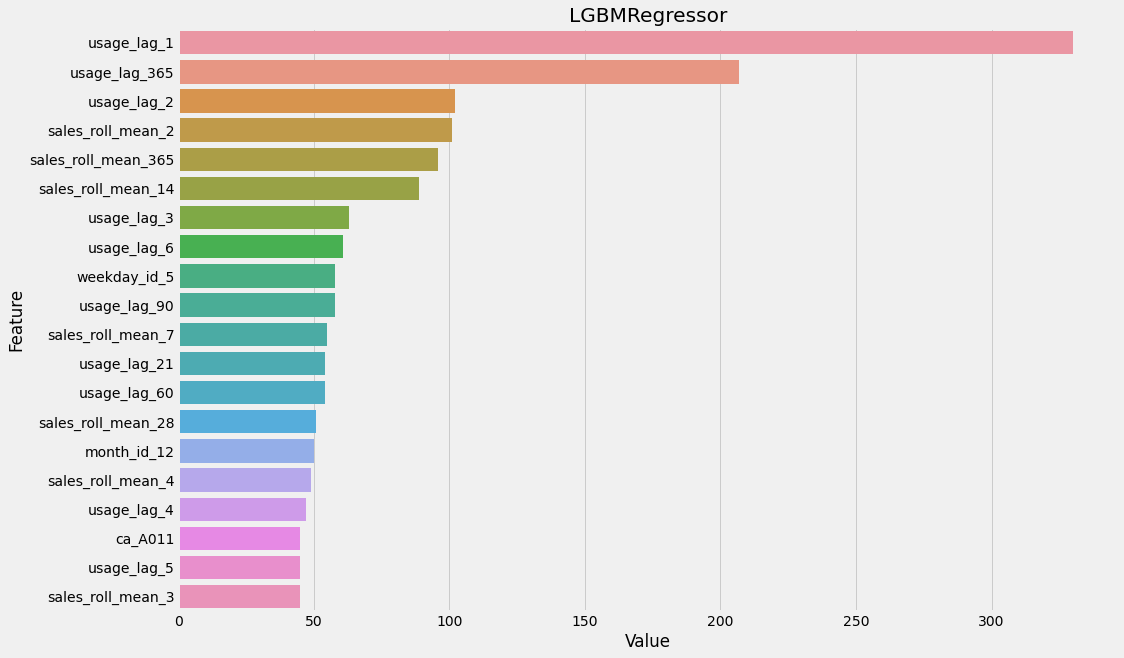

In [83]:
feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(15, 10))

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:20])
plt.title(str(type(model).__name__))
plt.savefig(str(type(model).__name__) + '.png')
plt.show()

A importancia das variaveis pode ser vista no grafico acima 

# Compare Series

Comparativo do **Real vs Predito** de utilização do metro por algumas estações 

In [105]:
df_compare_test = pd.concat([X_test, Y_test], axis=1)
df_compare_test['Pred'] =  eval_preds

Comparando volumetria da estação: station_PENNSYLVANIA AV
MAE: 7982726.693


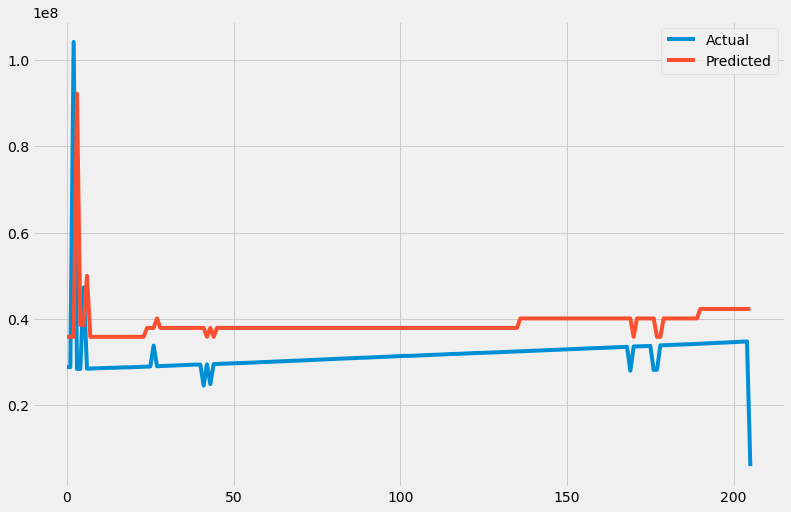

Comparando volumetria da estação: station_PRESIDENT ST
MAE: 3599664.861


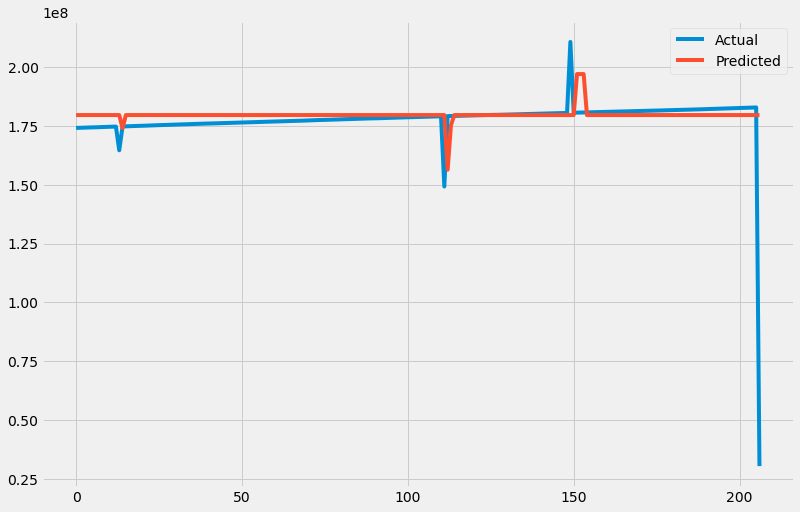

Comparando volumetria da estação: station_PRINCE ST
MAE: 14898557.033


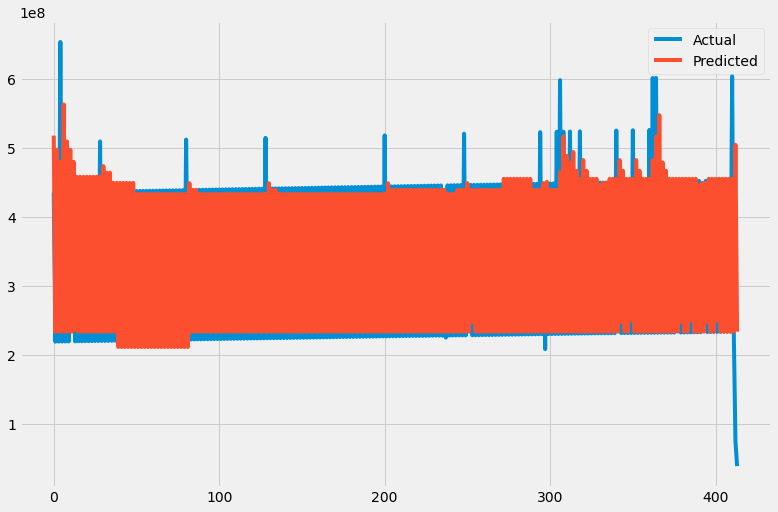

In [121]:
for col in df_compare_test.columns[520:523]:
    
    print("Comparando volumetria da estação:", col)
    
    plt.figure(figsize=(12, 8))
    y_true = df_compare_test[df_compare_test[col] == True]['USAGE'].values
    y_pred = df_compare_test[df_compare_test[col] == True]['Pred'].values
    mae = mean_absolute_error(y_true, y_pred)
    print('MAE: %.3f' % mae)
    # plot expected vs actual
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

## Conclusão

O dataset foi bastante interessante de se trabalhar, ele possui varias caracteristicas particulares como a estruturação das estações de metro e de localização. Dito isso, apos algumas analises, foi possivel perceber que a abordagem tradicional de forecasting utilizando o dado **USAGE** acumulado não traria um ganho operacional pensando em aplicação real e tambem não teria uma boa performance devido ao dataset possuir uma caracteristica de um dataset de serie temporal hierarquica onde este possui uma serie de niveis diferentes **Ex:(Estações, UNIT, CA)**. A modelagem realizada foi realizada pensando nesta caracteristica e atingiu uma performance dentro das expectativas, apesar de ser possivel realizar algumas otimizações e outros testes.